### Part 0: Context

The paper referenced is "Redistricting in a GIS environment: An optimisation algorithm using switching-points" by W. Macmillan. Their algorithm requires a swap to preserve contiguity and aims to optimize (minimize) population deviation using a simulated annealing approach. A swap involves moving one zone from one region to another region. The effect on both regions are kept track of.

Here, the algorithm requires a swap to (1) maintain a population deviation within 0.5% of the original district, (2) preserve contiguity, and (3) maintain a Polsby-Popper compactness score of within 5% of the original district. It aims to optimize (maximize) the change in margin of victory (MoV) for the winning party of the original district. Here, a positive MoV indicates a Democratic win and a negative MoV indicates a Republican win. E.g. with these standards, we would prefer a final hypothetical district with a new MoV of 0.2 to one with MoV -0.1 if the original MoV was -0.3. Note that our conclusion if the "best" hypothetical district we find has a new MoV with a different sign may not be that packing has occurred (i.e. we may not be concluding that the original district's winning party's votes were diluted to disenfranchise them if we find a new hypothetical district in which they don't win at all). A swap involves moving one precinct into or out of our target district. Only the effect on the target district is kept track of.

### Potential Changes / Issues

- Edit the probability calculations
- Vary the temperature cooling schedule (initial temperature, minimum temperature, reduction factor, thresholds)
- Instead of aiming to get below a certain cut-off MoV, end the process if the MoV plateaus for however long (stays within however much of its predecessors for however many loops). The paper ends the process after they get a new districting that gets below a cut-off, but not sure how well that works here. When running the code with district 3, there was a period of time where the MoV was changing between values between -0.220 and -0.240 for a while and I'm not immediately sure whether it was simply a matter of time before it finally reached a state where it would have nothing valid left to switch with (maybe it's a matter of altering the minimum temperature?) and end, before it managed to get even lower and pass the cut-off, or whether it would keep generating new maps in this range forever. Not sure if worth pursuing or if we would rather just manually set more conservative cut-offs / separately determine target cut-offs.

### Potential bottlenecks (time-wise)

- It doesn't seem like running 1 loop is that slow. What could be contributing to the time for a loop is the fact that at times compactness is calculated many times (handling geodata would take more time) as new precincts are chosen and tested for contiguity/compactness before the code proceeds to actually determine if the precinct will be swapped. Precincts aren't chosen to be tested by a determined order (precincts that would decrease the winning party's lead more dramatically are more likely, though not guaranteed, to be chosen), might be affecting how often we need to re-select a precinct to be tested within a loop in order to pass the compactness check.
- The fact that sometimes swaps that are not bringing our final MoV closer to the target are being made does result in more loops needing to be run.
- I chose the temperature cooling schedule fairly arbitrarily to test things here. Many papers seem to be dedicated to calculating optimal schedules specifically. Not sure if we are invested enough in this method to be interested in pursuing that avenue further. As it stands, even after the cooling schedule ends and we reach our final temperature value, we still keep a (small) probability that a swap that moves us away from our target could still be accepted. Not sure if that's something we would want to change or look into further.
- As noted above, it does appear to spend time generating values in a certain range and not get much further faster at times? Not immediately sure if it will get permanently stuck in the range due to the numbers/set up of the algo here.

### Part 1: Set-Up

In [31]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [32]:
pd.set_option('display.max_rows', 10, 'display.max_columns', None)

In [33]:
data = gpd.read_file('../Data/cen_prec_data4/cen_prec_data4.shp')

In [34]:
data.columns

Index(['COUNTY_NAM', 'loc_prec', 'special', 'district', 'writein', 'votes',
       'dem_votes', 'rep_votes', 'lib_votes', 'dem_prop', 'rep_prop',
       'lib_prop', 'abs_dem', 'abs_rep', 'abs_lib', 'total_dem', 'total_rep',
       'total_lib', 'total_vote', 'dem_percen', 'rep_percen', 'my_neighbo',
       'HOUSING10', 'total_pop', 'total_18+', 'hispanic', 'not_hispan',
       'pop_1_race', 'white', 'african_am', 'am_indian_', 'asian',
       'hawaii/pac', 'other_race', '2+races', 'minority', 'geometry'],
      dtype='object')

### Part 2: Methods

In [35]:
# Get all precincts that border a district
def get_neighbours(district):
    potential_neighbours = set() # all precincts that border a precinct from district, including precincts in district
    precinct_list = district['my_neighbo'].tolist()
    for precinct_str in precinct_list:
        precincts = precinct_str.split(', ')
        potential_neighbours.update(precincts)

    neighbours = set() # neighbouring precincts
    district_list = district['loc_prec'].tolist()
    neighbours = potential_neighbours - set(district_list)
    return neighbours

In [36]:
# Get all precincts that are within a district on its border
def get_boundary(district, neighbours):
    boundary = set() # boundary precincts
    for index, row in district.iterrows():
        if not set(row['my_neighbo'].split(', ')).isdisjoint(neighbours):
            boundary.add(row['loc_prec'])

    return boundary

In [37]:
# Calculate the margin of victory.
# "Margin" is the absolute value of the returned MoV value
# Positive MoV indicates a Democratic win
# Negative MoV indicates a Republican win
def marginofvic(dem, rep, votes):
    return (dem - rep) / votes

In [38]:
# Calculate the Polsby Popper compactness score
def polsby_popper(shape):
    return (4 * np.pi * shape.area) / (shape.length ** 2)

In [39]:
# Print basic district information
def print_head(NUM, district, pop, mov, compact):
    print('District', NUM, 'with', len(district), 'precincts.')
    print('Current Polsby-Popper:', compact, '     Current MOV:', mov)

In [40]:
# Create a basic whatif dataframe
def basic_whatif(state):
    
    # Create is_neighbour column. 
    # 1 = neighbouring precinct (would be inserted into district if swap made)
    # -1 = boundary precinct (would be deleted from district if swap made)
    whatif = state.loc[state['loc_prec'].isin(neighbours|boundary), ['loc_prec', 'total_dem', 'total_rep', 'total_vote', 'total_pop', 'geometry']].copy()
    whatif.loc[whatif['loc_prec'].isin(neighbours), 'is_neighbour'] = 1
    whatif.loc[whatif['loc_prec'].isin(boundary), 'is_neighbour'] = -1
    
    # Adjust following columns by is_neighbour value so that adding new values accounts for whether a precinct
    # would be inserted or deleted from the district if it is swapped
    whatif['total_pop'] = whatif['is_neighbour'] * whatif['total_pop']
    whatif['total_vote'] = whatif['is_neighbour'] * whatif['total_vote']
    whatif['total_dem'] = whatif['is_neighbour'] * whatif['total_dem']
    whatif['total_rep'] = whatif['is_neighbour'] * whatif['total_rep']
    
    return whatif

In [41]:
# Calculate new hypothetical population deviations if a swap is made for each precinct
def hyp_popdev(whatif, ideal_pop, pop):
    whatif['hyp_popdev'] = ((pop + whatif['total_pop']) - ideal_pop) / ideal_pop
    return whatif

In [42]:
# Calculate helpful MoV related values for if a swap is made for a precicnt
def hyp_movchange(whatif, dem, rep, votes, mov):
    new_dem = dem + whatif['total_dem']
    new_rep = rep + whatif['total_rep']
    new_votes = votes + whatif['total_vote']
    
    # New MoV for the hypothetical district created if each precinct is swapped
    whatif['hyp_mov'] = marginofvic(new_dem, new_rep, new_votes)
    
    # Change in MoV from current to hypothetical district if a swap is made.
    # Adjusted so that a negative value = decrease in the winner's lead; pos = increase in winner's lead
    whatif['hyp_movchg'] = (whatif['hyp_mov'] - mov) * np.sign(mov)
    return whatif

##### In the paper, the probability of selecting a precinct for swapping would be calculated:

Pmn = abs(population deviation)  
Pm = max population deviation

probability = (Pm - Pmn) / sigma(Pm - Pmn)

##### Here: 

Pmn = amount of decrease in the winner's lead (more negative, greater decrease)  
Pm = minimum decrease

probability = (Pm - Pmn) / sigma(Pm - Pmn)

In [43]:
# Calculate more helpful MoV related values for if a swap is made for a precinct
def mov_prob(whatif, mov):
    min_decrease = whatif['hyp_movchg'].max()
    max_decrease = whatif['hyp_movchg'].min()
    
    # Adjusts MoV change relative to the minimum decrease (min decrease = 0, max decrease = most positive number)
    whatif['mov_comp'] = min_decrease - whatif['hyp_movchg']
    
    # Adjusts MoV change relative to maximum decrease (max decrease = 0, min decrease = most positive number)
    whatif['mov_comp2'] = whatif['hyp_movchg'] - max_decrease
    
    # Calculates the probability of selecting a given precinct for swapping as detailed in markdown above
    whatif['mov_prob'] = whatif['mov_comp'] / whatif['mov_comp'].sum() 
    return whatif

In [44]:
# Get Polygon shape of new district
def get_new_shape(whatif, draw, shape):
    is_neighbour = whatif.loc[whatif['loc_prec'] == draw, 'is_neighbour'].values[0]
    prec_shape = whatif.loc[whatif['loc_prec'] == draw, 'geometry'].values[0]
    
    if is_neighbour == 1:
        new_shape = shape.union(prec_shape)
    elif is_neighbour == -1:
        new_shape = shape.difference(prec_shape)
    else:
        print('Invalid entry in is_neighbour.')
        new_shape = None

    return new_shape

In [45]:
# Check if the new Polygon is a Polygon (not a MultiPolygon) and has no holes
def check_contiguity(new_shape):    
    if (new_shape.geom_type != 'Polygon') or (len(new_shape.interiors) > 0):
        print("Contiguity check failed! Select new precinct to test.")
        return False
    else:
        return True

In [46]:
# Check if the new Polygon would be close enough in compactness to the original district (not the current district)
def check_compactness(og_compact, new_shape):
    new_compact = polsby_popper(new_shape)
    dev = abs(new_compact - og_compact) / og_compact
    print('new:', new_compact, 'old:', og_compact, 'dev:', dev)
    
    if dev < 0.05:
        print("Compactness of", new_compact, "Check passed!")
        return True
    else:
        print("Compactness of", new_compact, "Check failed! Select new precinct to test.")
        return False

##### In the paper, 
the probability of swapping a precinct that doesn't meet population requirements is:

Pd1 = original population deviation of district 1 from ideal  
Pd2 = original population deviation of district 2 from ideal

Ps1 = population deviation of district 1 from ideal after subtracting precinct  
Pa2 = population deviation of district 2 from ideal after adding precinct

T = annealing temperature

probability = e^( - ( Ps1 + Pa2 - Pd1 - |Pd2| ) / T)

##### Here:

Pd = amount of increase in the winner's lead (whatif['mov_comp2'])

probability = e^( - ( Pd ) / T)

In [47]:
# Calculate the probability of making a swap if it doesn't meet requirements for changing margin of victory
def prob_swap(whatif, draw, T):
    var = whatif.loc[whatif['loc_prec'] == draw, 'mov_comp2'].values[0]
    input = (-1) * (var) / T
    return math.exp(input)

In [48]:
# Swap a precinct by altering what district a precinct is allocated to in the dataframe state
# If a precinct is inserted, change their value in the district column to equal NUM
# If a precinct is removed, change their value in the district column to equal 14 (outside of range of actual precincts)
# Does not maintain validity of other districts besides NUM after a swap
def swap_prec(state, draw, NUM, count):
    is_neighbour = whatif.loc[whatif['loc_prec'] == draw, 'is_neighbour'].values[0]
    
    # insert
    if is_neighbour == 1:
        print('Insert new precinct', draw)
        state.loc[state['loc_prec'] == draw, 'district'] = NUM
    else: # delete
        print('Delete new precinct', draw)
        state.loc[state['loc_prec'] == draw, 'district'] = 14

In [49]:
# Does not account for perfect 50-50 district
# Returns true of MoV indicates originally a Democratic district, false if Republican
def get_og_dem_win(og_mov):
    if og_mov > 0:
        og_dem_win = True
    else:
        og_dem_win = False
    return og_dem_win

In [50]:
# Check if reached final goal, should end loop
def check_mov_goal(og_dem_win, new_mov, mov_goal):
    if og_dem_win == True: # Originally Democratic district
        if new_mov <= mov_goal:
            return True
        else:
            return False
    else: # Originally Republican district
        if new_mov >= mov_goal:
            return True
        else:
            return False
        

### Part 3: Main

In [51]:
### Initialize

# Get ideal population
ideal_pop = data['total_pop'].sum() / 13
print('ideal pop:', ideal_pop)

# Set initial parameters for simulated annealing
T = 5 # initial temperature (used to calculate probability of making a swap even if conditions are not met)
T_min = 0.001 # minimum temperature value
reduction = 0.99 # reduction factor
successful = 0 # number of successful transfers
unsuccessful = 0 # number of unsuccessful transfers
threshold = 10 # threshold for (un)successful transfers before reducing temperature
mov_goal = -0.20 # if we find a district with margin of victory "<" mov_goal, we are done

ideal pop: 733498.6923076923


In [52]:
### Individual district set-up/selection

NUM = 3 # district being regenerated
state = data.copy() # data will always contain the uneditied data for the original districting
                    # state will contain the updating data where precincts are being reassigned districts
count = 0
og_district = data[data['district'] == NUM].copy()
og_shape = og_district.unary_union
og_compact = polsby_popper(og_shape)
print('og_compact:', og_compact)

og_mov = marginofvic(og_district['total_dem'].sum(), og_district['total_rep'].sum(), og_district['total_vote'].sum())
print('og_mov:', og_mov)

og_dem_win = get_og_dem_win(og_mov)
print(og_dem_win)

og_compact: 0.37314993299157767
og_mov: -0.3495197444910518
False


In [53]:
### Start timing
start = time.time()

========== LOOP 1 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.37314993299157767      Current MOV: -0.3495197444910518
Contiguity check failed! Select new precinct to test.
new: 0.34532308436283526 old: 0.37314993299157767 dev: 0.07457283565791363
Compactness of 0.34532308436283526 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3221935914138867 old: 0.37314993299157767 dev: 0.13655728454556923
Compactness of 0.3221935914138867 Check failed! Select new precinct to test.
new: 0.353401072568787 old: 0.37314993299157767 dev: 0.05292473259866945
Compactness of 0.353401072568787 Check failed! Select new precinct to test.
new: 0.36939585616659654 old: 0.37314993299157767 dev: 0.01006050515642426
Compactness of 0.36939585616659654 Check passed!
Found a precinct, PITT1506 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1506
New mov: -0.345951423

District 3 with 233 precincts.
Current Polsby-Popper: 0.35485713078381137      Current MOV: -0.3354636676127177
new: 0.3337808967256741 old: 0.37314993299157767 dev: 0.10550460494600207
Compactness of 0.3337808967256741 Check failed! Select new precinct to test.
new: 0.3409883739589247 old: 0.37314993299157767 dev: 0.08618937373192269
Compactness of 0.3409883739589247 Check failed! Select new precinct to test.
new: 0.32601918274390734 old: 0.37314993299157767 dev: 0.126305128530558
Compactness of 0.32601918274390734 Check failed! Select new precinct to test.
new: 0.3073759130610651 old: 0.37314993299157767 dev: 0.17626700185417735
Compactness of 0.3073759130610651 Check failed! Select new precinct to test.
new: 0.3526244981656106 old: 0.37314993299157767 dev: 0.05500586496535793
Compactness of 0.3526244981656106 Check failed! Select new precinct to test.
new: 0.34299345447076035 old: 0.37314993299157767 dev: 0.08081598267765998
Compactness of 0.34299345447076035 Check failed! Select ne

District 3 with 233 precincts.
Current Polsby-Popper: 0.3560068870672152      Current MOV: -0.3344455287483795
new: 0.3412179654563213 old: 0.37314993299157767 dev: 0.08557409425014442
Compactness of 0.3412179654563213 Check failed! Select new precinct to test.
new: 0.33990568820353845 old: 0.37314993299157767 dev: 0.08909085021540009
Compactness of 0.33990568820353845 Check failed! Select new precinct to test.
new: 0.3361411522733125 old: 0.37314993299157767 dev: 0.09917938460168639
Compactness of 0.3361411522733125 Check failed! Select new precinct to test.
new: 0.34503370181049 old: 0.37314993299157767 dev: 0.07534834846592965
Compactness of 0.34503370181049 Check failed! Select new precinct to test.
new: 0.3542565682913253 old: 0.37314993299157767 dev: 0.050632099941121576
Compactness of 0.3542565682913253 Check failed! Select new precinct to test.
new: 0.30824283580759376 old: 0.37314993299157767 dev: 0.1739437460530079
Compactness of 0.30824283580759376 Check failed! Select new p

District 3 with 232 precincts.
Current Polsby-Popper: 0.3548670141612721      Current MOV: -0.3263361010151789
new: 0.32667689293971136 old: 0.37314993299157767 dev: 0.1245425389180366
Compactness of 0.32667689293971136 Check failed! Select new precinct to test.
new: 0.3353153921776438 old: 0.37314993299157767 dev: 0.10139232911181537
Compactness of 0.3353153921776438 Check failed! Select new precinct to test.
new: 0.3174448706560518 old: 0.37314993299157767 dev: 0.1492833239682859
Compactness of 0.3174448706560518 Check failed! Select new precinct to test.
new: 0.35211119455071704 old: 0.37314993299157767 dev: 0.05638146112526701
Compactness of 0.35211119455071704 Check failed! Select new precinct to test.
new: 0.3402736434492346 old: 0.37314993299157767 dev: 0.08810477139516225
Compactness of 0.3402736434492346 Check failed! Select new precinct to test.
new: 0.3460664457666194 old: 0.37314993299157767 dev: 0.07258071040728176
Compactness of 0.3460664457666194 Check failed! Select new

District 3 with 234 precincts.
Current Polsby-Popper: 0.3603102365305542      Current MOV: -0.32415473442626114
new: 0.35840737966975944 old: 0.37314993299157767 dev: 0.039508390645084164
Compactness of 0.35840737966975944 Check passed!
Found a precinct, BEAUFORTWASH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.9975359206219443
Don't make swap.
New mov: -0.32415473442626114


========== LOOP 31 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3603102365305542      Current MOV: -0.32415473442626114
new: 0.34035263571862473 old: 0.37314993299157767 dev: 0.08789308096617883
Compactness of 0.34035263571862473 Check failed! Select new precinct to test.
new: 0.3438560455691822 old: 0.37314993299157767 dev: 0.07850433520795154
Compactness of 0.3438560455691822 Check failed! Select new precinct to test.
new: 0.3294476949823177 old: 0.37314993299157767 dev: 0.11711709997880768
Compactness of 0.3294476

new: 0.3162960209219591 old: 0.37314993299157767 dev: 0.15236211249943288
Compactness of 0.3162960209219591 Check failed! Select new precinct to test.
new: 0.3540826145161628 old: 0.37314993299157767 dev: 0.05109827656285614
Compactness of 0.3540826145161628 Check failed! Select new precinct to test.
new: 0.3582302188735877 old: 0.37314993299157767 dev: 0.03998316172369976
Compactness of 0.3582302188735877 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1512B
New mov: -0.3169795978579728
Thresholds reached. Reset with new T value of 2.0299999999999994 and starting new loop.


========== LOOP 39 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3582302188735877      Current MOV: -0.31697959785797275
new: 0.3955780863336574 old: 0.37314993299157767 dev: 0.06010493734320442
Compactness of 0.3955780863336574 Check failed! Select new precinct to test.
new: 0.34

District 3 with 232 precincts.
Current Polsby-Popper: 0.35656439291565695      Current MOV: -0.3156678267185255
new: 0.3488771752799538 old: 0.37314993299157767 dev: 0.0650482703213341
Compactness of 0.3488771752799538 Check failed! Select new precinct to test.
new: 0.34031885212682333 old: 0.37314993299157767 dev: 0.08798361720594323
Compactness of 0.34031885212682333 Check failed! Select new precinct to test.
new: 0.34188139844223353 old: 0.37314993299157767 dev: 0.08379616820150923
Compactness of 0.34188139844223353 Check failed! Select new precinct to test.
new: 0.35467653823635814 old: 0.37314993299157767 dev: 0.04950662755615848
Compactness of 0.35467653823635814 Check passed!
Found a precinct, BEAUFORTWASH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.9963769901109155
Make swap anyways!
Delete new precinct BEAUFORTWASH2
New mov: -0.3169726190768722


========== LOOP 46 ==========
District 3 with 231 prec

District 3 with 234 precincts.
Current Polsby-Popper: 0.3796733631180911      Current MOV: -0.32111763260839976
Contiguity check failed! Select new precinct to test.
new: 0.3796782742389198 old: 0.37314993299157767 dev: 0.017495222885352872
Compactness of 0.3796782742389198 Check passed!
Found a precinct, WASHINGTONSC with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.9976973299613515
Don't make swap.
New mov: -0.32111763260839976


========== LOOP 55 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3796733631180911      Current MOV: -0.32111763260839976
new: 0.36676767654064957 old: 0.37314993299157767 dev: 0.01710373200327536
Compactness of 0.36676767654064957 Check passed!
Found a precinct, ONSLOWNM13 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct ONSLOWNM13
New mov: -0.31947659339265505
Thresholds reached. Reset with new T val

District 3 with 231 precincts.
Current Polsby-Popper: 0.35454537825928967      Current MOV: -0.31585998668961623
new: 0.3571922522486828 old: 0.37314993299157767 dev: 0.04276479594934046
Compactness of 0.3571922522486828 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1512B
New mov: -0.3125090273127305


========== LOOP 64 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.3571922522486828      Current MOV: -0.3125090273127306
new: 0.30899459911062543 old: 0.37314993299157767 dev: 0.1719291046540273
Compactness of 0.30899459911062543 Check failed! Select new precinct to test.
new: 0.3330929366079707 old: 0.37314993299157767 dev: 0.10734826095898324
Compactness of 0.3330929366079707 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3144586830083898 old: 0.37314993299157767 dev: 0.1572859721899309
Compactn

District 3 with 231 precincts.
Current Polsby-Popper: 0.35536513788227814      Current MOV: -0.3124445704404128
new: 0.3449027607608783 old: 0.37314993299157767 dev: 0.07569925580379765
Compactness of 0.3449027607608783 Check failed! Select new precinct to test.
new: 0.3325546407681047 old: 0.37314993299157767 dev: 0.10879083348083902
Compactness of 0.3325546407681047 Check failed! Select new precinct to test.
new: 0.3123554408896263 old: 0.37314993299157767 dev: 0.16292242534939316
Compactness of 0.3123554408896263 Check failed! Select new precinct to test.
new: 0.31511829411320325 old: 0.37314993299157767 dev: 0.15551828835430678
Compactness of 0.31511829411320325 Check failed! Select new precinct to test.
new: 0.3330639614978943 old: 0.37314993299157767 dev: 0.10742591100663053
Compactness of 0.3330639614978943 Check failed! Select new precinct to test.
new: 0.35390469939565256 old: 0.37314993299157767 dev: 0.05157506914615873
Compactness of 0.35390469939565256 Check failed! Select 

District 3 with 232 precincts.
Current Polsby-Popper: 0.35733815649649836      Current MOV: -0.3124293093341642
new: 0.3603050071525054 old: 0.37314993299157767 dev: 0.03442296166608767
Compactness of 0.3603050071525054 Check passed!
Found a precinct, PITT1510A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.9097688088683358
Make swap anyways!
Insert new precinct PITT1510A
New mov: -0.31376343590722117


========== LOOP 84 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3603050071525054      Current MOV: -0.31376343590722133
new: 0.35197280491393174 old: 0.37314993299157767 dev: 0.05675232984196709
Compactness of 0.35197280491393174 Check failed! Select new precinct to test.
new: 0.3513762041890054 old: 0.37314993299157767 dev: 0.05835115292132112
Compactness of 0.3513762041890054 Check failed! Select new precinct to test.
new: 0.33769745016197616 old: 0.37314993299157767 dev: 0.0950086806806466

District 3 with 231 precincts.
Current Polsby-Popper: 0.3570668500526827      Current MOV: -0.31334830841035144
new: 0.30983554559426 old: 0.37314993299157767 dev: 0.1696754623261495
Compactness of 0.30983554559426 Check failed! Select new precinct to test.
new: 0.3727698054594313 old: 0.37314993299157767 dev: 0.001018699183727229
Compactness of 0.3727698054594313 Check passed!
Found a precinct, ONSLOWCL10 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 1.0084583551724793
Don't make swap.
New mov: -0.31334830841035144


========== LOOP 94 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.3570668500526827      Current MOV: -0.31334830841035144
Contiguity check failed! Select new precinct to test.
new: 0.33689547723171964 old: 0.37314993299157767 dev: 0.09715787825339453
Compactness of 0.33689547723171964 Check failed! Select new precinct to test.
new: 0.34018520006353026 old: 0.37314993299157767 dev:

District 3 with 231 precincts.
Current Polsby-Popper: 0.36753656652764866      Current MOV: -0.29951203247387514
new: 0.34629277549119475 old: 0.37314993299157767 dev: 0.0719741721111045
Compactness of 0.34629277549119475 Check failed! Select new precinct to test.
new: 0.3467176075412495 old: 0.37314993299157767 dev: 0.07083566982959849
Compactness of 0.3467176075412495 Check failed! Select new precinct to test.
new: 0.364049752170623 old: 0.37314993299157767 dev: 0.024387464706204436
Compactness of 0.364049752170623 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BEAUFORTPSJW3
New mov: -0.29682131284588675
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 104 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.364049752170623      Current MOV: -0.2968213128458867
new: 0.33532715366681315 old: 0.37314993299157767 de

District 3 with 232 precincts.
Current Polsby-Popper: 0.3785008784598433      Current MOV: -0.298668769963897
new: 0.3665361265552277 old: 0.37314993299157767 dev: 0.017724260013465516
Compactness of 0.3665361265552277 Check passed!
Found a precinct, PITT0800B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct PITT0800B
New mov: -0.29851680368478095
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 113 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.3665361265552277      Current MOV: -0.298516803684781
new: 0.3680248579694606 old: 0.37314993299157767 dev: 0.013734626671453113
Compactness of 0.3680248579694606 Check passed!
Found a precinct, CHOWAN4 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct CHOWAN4
New mov: -0.29823387423930686
Thresholds reached, but T already at a minumum of 0.001 Star

District 3 with 231 precincts.
Current Polsby-Popper: 0.3597661209183576      Current MOV: -0.29862257076779297
new: 0.3396511299097489 old: 0.37314993299157767 dev: 0.08977303791338181
Compactness of 0.3396511299097489 Check failed! Select new precinct to test.
new: 0.3507894520808162 old: 0.37314993299157767 dev: 0.0599235828115938
Compactness of 0.3507894520808162 Check failed! Select new precinct to test.
new: 0.3975979218973635 old: 0.37314993299157767 dev: 0.06551787028282174
Compactness of 0.3975979218973635 Check failed! Select new precinct to test.
new: 0.33210881280623455 old: 0.37314993299157767 dev: 0.10998560245291389
Compactness of 0.33210881280623455 Check failed! Select new precinct to test.
new: 0.3556832645093576 old: 0.37314993299157767 dev: 0.04680871397239216
Compactness of 0.3556832645093576 Check passed!
Found a precinct, BEAUFORTWASHP with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct BEAUFORTWASH

District 3 with 231 precincts.
Current Polsby-Popper: 0.3679172337580803      Current MOV: -0.300273205224326
new: 0.37102989145550475 old: 0.37314993299157767 dev: 0.005681473715073068
Compactness of 0.37102989145550475 Check passed!
Found a precinct, PITT1510A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.000615117893083672
Don't make swap.
New mov: -0.300273205224326
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 129 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.3679172337580803      Current MOV: -0.300273205224326
new: 0.3403888217455715 old: 0.37314993299157767 dev: 0.08779610646947542
Compactness of 0.3403888217455715 Check failed! Select new precinct to test.
new: 0.35928091224725867 old: 0.37314993299157767 dev: 0.03716742123770404
Compactness of 0.35928091224725867 Check passed!
Found a precinct, DUPLINCFRK with valid contiguity and comp

District 3 with 229 precincts.
Current Polsby-Popper: 0.3584857500037205      Current MOV: -0.2983589360688775
new: 0.3594235409756694 old: 0.37314993299157767 dev: 0.03678519223053986
Compactness of 0.3594235409756694 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.001408931448421125
Make swap anyways!
Delete new precinct PITT1101
New mov: -0.2988979914974254
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 136 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.3594235409756694      Current MOV: -0.2988979914974253
new: 0.3547844421284564 old: 0.37314993299157767 dev: 0.0492174572185594
Compactness of 0.3547844421284564 Check passed!
Found a precinct, ONSLOWCL10 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct ONSLOWCL10
New mov: -0.29689570213510

District 3 with 228 precincts.
Current Polsby-Popper: 0.3574144554443771      Current MOV: -0.29261789122861975
Contiguity check failed! Select new precinct to test.
new: 0.3183676261413383 old: 0.37314993299157767 dev: 0.14681044268464566
Compactness of 0.3183676261413383 Check failed! Select new precinct to test.
new: 0.32658584572400473 old: 0.37314993299157767 dev: 0.12478653525210183
Compactness of 0.32658584572400473 Check failed! Select new precinct to test.
new: 0.34703110087217287 old: 0.37314993299157767 dev: 0.0699955428371853
Compactness of 0.34703110087217287 Check failed! Select new precinct to test.
new: 0.29059970201913 old: 0.37314993299157767 dev: 0.2212253672689549
Compactness of 0.29059970201913 Check failed! Select new precinct to test.
new: 0.34430571142677086 old: 0.37314993299157767 dev: 0.07729928110547954
Compactness of 0.34430571142677086 Check failed! Select new precinct to test.
new: 0.332044051327113 old: 0.37314993299157767 dev: 0.11015915595887955
Compac

District 3 with 229 precincts.
Current Polsby-Popper: 0.3554606686359048      Current MOV: -0.29442688432217345
new: 0.3461111312269973 old: 0.37314993299157767 dev: 0.07246095838154856
Compactness of 0.3461111312269973 Check failed! Select new precinct to test.
new: 0.3497414947120391 old: 0.37314993299157767 dev: 0.06273199111110905
Compactness of 0.3497414947120391 Check failed! Select new precinct to test.
new: 0.3525528229673514 old: 0.37314993299157767 dev: 0.05519794646376409
Compactness of 0.3525528229673514 Check failed! Select new precinct to test.
new: 0.33561706897613314 old: 0.37314993299157767 dev: 0.10058386910199897
Compactness of 0.33561706897613314 Check failed! Select new precinct to test.
new: 0.31520040933699345 old: 0.37314993299157767 dev: 0.1552982287575332
Compactness of 0.31520040933699345 Check failed! Select new precinct to test.
new: 0.35543220100247525 old: 0.37314993299157767 dev: 0.04748153603313746
Compactness of 0.35543220100247525 Check passed!
Found 

District 3 with 229 precincts.
Current Polsby-Popper: 0.3612334538951688      Current MOV: -0.2934042427792608
new: 0.320896972008312 old: 0.37314993299157767 dev: 0.140032079235145
Compactness of 0.320896972008312 Check failed! Select new precinct to test.
new: 0.34775920502458396 old: 0.37314993299157767 dev: 0.06804430531029146
Compactness of 0.34775920502458396 Check failed! Select new precinct to test.
new: 0.333476373284468 old: 0.37314993299157767 dev: 0.10632069363926468
Compactness of 0.333476373284468 Check failed! Select new precinct to test.
new: 0.34214787109473743 old: 0.37314993299157767 dev: 0.08308205135746329
Compactness of 0.34214787109473743 Check failed! Select new precinct to test.
new: 0.329198413900134 old: 0.37314993299157767 dev: 0.11778514534112407
Compactness of 0.329198413900134 Check failed! Select new precinct to test.
new: 0.3121163615947971 old: 0.37314993299157767 dev: 0.1635631310649549
Compactness of 0.3121163615947971 Check failed! Select new precin

District 3 with 228 precincts.
Current Polsby-Popper: 0.377898144137127      Current MOV: -0.29387606024001756
new: 0.3676773334343909 old: 0.37314993299157767 dev: 0.014665953476964137
Compactness of 0.3676773334343909 Check passed!
Found a precinct, LENOIRT2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct LENOIRT2
New mov: -0.2929330448738299
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 162 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.3676773334343909      Current MOV: -0.29293304487382993
new: 0.3616633326392704 old: 0.37314993299157767 dev: 0.030782801594571144
Compactness of 0.3616633326392704 Check passed!
Found a precinct, PERQUIMANSBELVID with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct PERQUIMANSBELVID
New mov: -0.2926665154210499
Thresholds reached, but T already at a minu

District 3 with 228 precincts.
Current Polsby-Popper: 0.3546749510610998      Current MOV: -0.28970417783979513
new: 0.30353871051386816 old: 0.37314993299157767 dev: 0.18655027462990512
Compactness of 0.30353871051386816 Check failed! Select new precinct to test.
new: 0.3255077163315453 old: 0.37314993299157767 dev: 0.12767580119358538
Compactness of 0.3255077163315453 Check failed! Select new precinct to test.
new: 0.3348695005549643 old: 0.37314993299157767 dev: 0.10258726868772454
Compactness of 0.3348695005549643 Check failed! Select new precinct to test.
new: 0.3461520870564026 old: 0.37314993299157767 dev: 0.07235120134882735
Compactness of 0.3461520870564026 Check failed! Select new precinct to test.
new: 0.32755672063942265 old: 0.37314993299157767 dev: 0.12218469928864788
Compactness of 0.32755672063942265 Check failed! Select new precinct to test.
new: 0.3145079606716872 old: 0.37314993299157767 dev: 0.15715391357504033
Compactness of 0.3145079606716872 Check failed! Select 

District 3 with 226 precincts.
Current Polsby-Popper: 0.3561760327609369      Current MOV: -0.2940949440521032
new: 0.3477450386812694 old: 0.37314993299157767 dev: 0.06808226952269532
Compactness of 0.3477450386812694 Check failed! Select new precinct to test.
new: 0.32749189364255005 old: 0.37314993299157767 dev: 0.12235842837484354
Compactness of 0.32749189364255005 Check failed! Select new precinct to test.
new: 0.35790999941613455 old: 0.37314993299157767 dev: 0.04084131398138855
Compactness of 0.35790999941613455 Check passed!
Found a precinct, CHOWAN2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0016066506752447699
Make swap anyways!
Delete new precinct CHOWAN2
New mov: -0.29618336739764395
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 175 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.35790999941613455      Current MOV: -0.29618336739764

new: 0.34762156802092814 old: 0.37314993299157767 dev: 0.06841315705455514
Compactness of 0.34762156802092814 Check failed! Select new precinct to test.
new: 0.3258515233335405 old: 0.37314993299157767 dev: 0.12675443696007507
Compactness of 0.3258515233335405 Check failed! Select new precinct to test.
new: 0.3445157697810629 old: 0.37314993299157767 dev: 0.0767363482580635
Compactness of 0.3445157697810629 Check failed! Select new precinct to test.
new: 0.30571945933526024 old: 0.37314993299157767 dev: 0.18070611219388696
Compactness of 0.30571945933526024 Check failed! Select new precinct to test.
new: 0.353786176631759 old: 0.37314993299157767 dev: 0.0518926968700695
Compactness of 0.353786176631759 Check failed! Select new precinct to test.
new: 0.28890580976957825 old: 0.37314993299157767 dev: 0.22576480865641985
Compactness of 0.28890580976957825 Check failed! Select new precinct to test.
new: 0.34303213190348936 old: 0.37314993299157767 dev: 0.08071233149268206
Compactness of 0.

District 3 with 230 precincts.
Current Polsby-Popper: 0.35662802938199384      Current MOV: -0.29045973988526674
new: 0.33728148820568743 old: 0.37314993299157767 dev: 0.096123412104967
Compactness of 0.33728148820568743 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.32512587548204036 old: 0.37314993299157767 dev: 0.12869909187581513
Compactness of 0.32512587548204036 Check failed! Select new precinct to test.
new: 0.3287347702863543 old: 0.37314993299157767 dev: 0.1190276582636446
Compactness of 0.3287347702863543 Check failed! Select new precinct to test.
new: 0.3069892077590031 old: 0.37314993299157767 dev: 0.17730332872408114
Compactness of 0.3069892077590031 Check failed! Select new precinct to test.
new: 0.3325357661959055 old: 0.37314993299157767 dev: 0.10884141521898343
Compactness of 0.3325357661959055 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3577513261710328

District 3 with 231 precincts.
Current Polsby-Popper: 0.367981763899911      Current MOV: -0.2883265718752205
new: 0.34722293854913083 old: 0.37314993299157767 dev: 0.06948143936295986
Compactness of 0.34722293854913083 Check failed! Select new precinct to test.
new: 0.3372086379690933 old: 0.37314993299157767 dev: 0.09631864257441958
Compactness of 0.3372086379690933 Check failed! Select new precinct to test.
new: 0.3612737050507863 old: 0.37314993299157767 dev: 0.03182695986457382
Compactness of 0.3612737050507863 Check passed!
Found a precinct, BEAUFORTOLDF with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BEAUFORTOLDF
New mov: -0.28806129281255693
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 192 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.3612737050507863      Current MOV: -0.28806129281255677
new: 0.3355750483349988 old: 0.37314993299157767 dev:

new: 0.3666366399749928 old: 0.37314993299157767 dev: 0.017454895313439293
Compactness of 0.3666366399749928 Check passed!
Found a precinct, PITT0800B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.023583658920927984
Don't make swap.
New mov: -0.28849964145483104
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 195 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.35527907223788313      Current MOV: -0.28849964145483104
new: 0.34803301323706803 old: 0.37314993299157767 dev: 0.06731052998762443
Compactness of 0.34803301323706803 Check failed! Select new precinct to test.
new: 0.3612737050507863 old: 0.37314993299157767 dev: 0.03182695986457382
Compactness of 0.3612737050507863 Check passed!
Found a precinct, CHOWAN5 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct CHOWAN5
New mov: -0.288

District 3 with 230 precincts.
Current Polsby-Popper: 0.36030825985817583      Current MOV: -0.2912357654884864
new: 0.35936626296824753 old: 0.37314993299157767 dev: 0.0369386908710533
Compactness of 0.35936626296824753 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1101
New mov: -0.2907362403736291
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 203 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.35936626296824753      Current MOV: -0.2907362403736291
new: 0.3268575103896002 old: 0.37314993299157767 dev: 0.12405850439486031
Compactness of 0.3268575103896002 Check failed! Select new precinct to test.
new: 0.3270724167970587 old: 0.37314993299157767 dev: 0.12348257930829913
Compactness of 0.3270724167970587 Check failed! Select new precinct to test.
new: 0.33984599233082735 old: 0.37314993299157767 dev: 0.0892

District 3 with 232 precincts.
Current Polsby-Popper: 0.3605437852393181      Current MOV: -0.2900600994705166
new: 0.30848119955526365 old: 0.37314993299157767 dev: 0.17330495792363884
Compactness of 0.30848119955526365 Check failed! Select new precinct to test.
new: 0.3295079689176242 old: 0.37314993299157767 dev: 0.11695557258732919
Compactness of 0.3295079689176242 Check failed! Select new precinct to test.
new: 0.35864605842438213 old: 0.37314993299157767 dev: 0.03886875833238567
Compactness of 0.35864605842438213 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0020258553085820306
Don't make swap.
New mov: -0.2900600994705166
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 212 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.3605437852393181      Current MOV: -0.2900600994705166
new: 0.3498288046211310

District 3 with 232 precincts.
Current Polsby-Popper: 0.3633023889037887      Current MOV: -0.29276650004384996
Contiguity check failed! Select new precinct to test.
new: 0.36323429501166205 old: 0.37314993299157767 dev: 0.026572798500648347
Compactness of 0.36323429501166205 Check passed!
Found a precinct, WASHINGTONSC with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.007768640046009997
Don't make swap.
New mov: -0.29276650004384996
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 219 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.3633023889037887      Current MOV: -0.29276650004384996
new: 0.36215850913948033 old: 0.37314993299157767 dev: 0.029455784070435365
Compactness of 0.36215850913948033 Check passed!
Found a precinct, PITT1508B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap:

District 3 with 230 precincts.
Current Polsby-Popper: 0.36281004990065235      Current MOV: -0.2910505103259592
new: 0.35070525259486907 old: 0.37314993299157767 dev: 0.06014922799735623
Compactness of 0.35070525259486907 Check failed! Select new precinct to test.
new: 0.33928822982528944 old: 0.37314993299157767 dev: 0.09074556946805754
Compactness of 0.33928822982528944 Check failed! Select new precinct to test.
new: 0.3556408110033152 old: 0.37314993299157767 dev: 0.04692248461065029
Compactness of 0.3556408110033152 Check passed!
Found a precinct, PITT1102A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.004371517631888395
Make swap anyways!
Insert new precinct PITT1102A
New mov: -0.29222770607491483
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 231 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.3556408110033152      Current MOV: -0.29222770607

District 3 with 231 precincts.
Current Polsby-Popper: 0.38875247342445496      Current MOV: -0.2902875696741114
new: 0.36150435540393866 old: 0.37314993299157767 dev: 0.03120884276804054
Compactness of 0.36150435540393866 Check passed!
Found a precinct, GATES4N with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct GATES4N
New mov: -0.28995770741429827
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 239 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.36150435540393866      Current MOV: -0.2899577074142983
new: 0.3318102175771869 old: 0.37314993299157767 dev: 0.1107858042019905
Compactness of 0.3318102175771869 Check failed! Select new precinct to test.
new: 0.3292029599796889 old: 0.37314993299157767 dev: 0.11777296235741436
Compactness of 0.3292029599796889 Check failed! Select new precinct to test.
new: 0.3688825601265964 old: 0.37314993299157767 dev: 0.011436

District 3 with 231 precincts.
Current Polsby-Popper: 0.36673988682563063      Current MOV: -0.2893834155560932
new: 0.3545532650579994 old: 0.37314993299157767 dev: 0.049836985858437835
Compactness of 0.3545532650579994 Check passed!
Found a precinct, ONSLOWNM13 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct ONSLOWNM13
New mov: -0.2876065163920556
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 248 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3545532650579994      Current MOV: -0.2876065163920556
new: 0.36673988682563063 old: 0.37314993299157767 dev: 0.0171782053250207
Compactness of 0.36673988682563063 Check passed!
Found a precinct, ONSLOWNM13 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0025136787305883776
Don't make swap.
New mov: -0.2876065163920556
Thresholds reached, b

District 3 with 232 precincts.
Current Polsby-Popper: 0.3627220777158726      Current MOV: -0.2807153594932671
new: 0.37199547575264225 old: 0.37314993299157767 dev: 0.003093816015669717
Compactness of 0.37199547575264225 Check passed!
Found a precinct, LENOIRPH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.008655608706529226
Make swap anyways!
Insert new precinct LENOIRPH2
New mov: -0.28184288525271456
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 258 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.37199547575264225      Current MOV: -0.28184288525271456
Contiguity check failed! Select new precinct to test.
new: 0.3672157945029556 old: 0.37314993299157767 dev: 0.015902826086681903
Compactness of 0.3672157945029556 Check passed!
Found a precinct, ONSLOWCL10 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make

District 3 with 232 precincts.
Current Polsby-Popper: 0.3576674291133858      Current MOV: -0.2823174787030068
new: 0.33903647039665963 old: 0.37314993299157767 dev: 0.09142025652109126
Compactness of 0.33903647039665963 Check failed! Select new precinct to test.
new: 0.33187443088362883 old: 0.37314993299157767 dev: 0.11061371973737018
Compactness of 0.33187443088362883 Check failed! Select new precinct to test.
new: 0.35250228902307734 old: 0.37314993299157767 dev: 0.05533337177087572
Compactness of 0.35250228902307734 Check failed! Select new precinct to test.
new: 0.36403574743325456 old: 0.37314993299157767 dev: 0.02442499583278452
Compactness of 0.36403574743325456 Check passed!
Found a precinct, BEAUFORTWASH1 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BEAUFORTWASH1
New mov: -0.2807182791632779
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 268 ==========
Distri

District 3 with 232 precincts.
Current Polsby-Popper: 0.35731147073800745      Current MOV: -0.27724927723112514
new: 0.33447296413339705 old: 0.37314993299157767 dev: 0.10364994185608922
Compactness of 0.33447296413339705 Check failed! Select new precinct to test.
new: 0.35578013405724024 old: 0.37314993299157767 dev: 0.0465491144406275
Compactness of 0.35578013405724024 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0010957220373801725
Make swap anyways!
Delete new precinct PITT1512B
New mov: -0.2803988068638832
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 279 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.35578013405724024      Current MOV: -0.2803988068638832
new: 0.341194511744024 old: 0.37314993299157767 dev: 0.0856369475705492
Compactness of 0.341194511744024 Check failed! Select new precinct to te

District 3 with 233 precincts.
Current Polsby-Popper: 0.3562398677421199      Current MOV: -0.2698138546716718
new: 0.3256983579472795 old: 0.37314993299157767 dev: 0.12716490302939212
Compactness of 0.3256983579472795 Check failed! Select new precinct to test.
new: 0.33889579262111363 old: 0.37314993299157767 dev: 0.09179725719322904
Compactness of 0.33889579262111363 Check failed! Select new precinct to test.
new: 0.3488978451356196 old: 0.37314993299157767 dev: 0.06499287742470385
Compactness of 0.3488978451356196 Check failed! Select new precinct to test.
new: 0.3363535628548391 old: 0.37314993299157767 dev: 0.09861014804890536
Compactness of 0.3363535628548391 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3517464797990338 old: 0.37314993299157767 dev: 0.0573588557847255
Compactness of 0.3517464797990338 Check failed! Select new precinct to test.
new: 0.3093137526476283 old: 0.37314993299157767 dev: 0.17107380894368332
Compa

District 3 with 232 precincts.
Current Polsby-Popper: 0.35583721727425743      Current MOV: -0.27206999105424007
new: 0.3385361287603298 old: 0.37314993299157767 dev: 0.0927611160311508
Compactness of 0.3385361287603298 Check failed! Select new precinct to test.
new: 0.3484614551642117 old: 0.37314993299157767 dev: 0.06616235364009361
Compactness of 0.3484614551642117 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.33898886335037826 old: 0.37314993299157767 dev: 0.09154783806961171
Compactness of 0.33898886335037826 Check failed! Select new precinct to test.
new: 0.32698832775842923 old: 0.37314993299157767 dev: 0.12370792850762846
Compactness of 0.32698832775842923 Check failed! Select new precinct to test.
new: 0.3415617211547677 old: 0.37314993299157767 dev: 0.08465286750439524
Compactness of 0.3415617211547677 Check failed! Select new precinct to test.
new: 0.33632300463181697 old: 0.37314993299157767 dev: 0.09869204066182137


District 3 with 234 precincts.
Current Polsby-Popper: 0.35772139104077116      Current MOV: -0.26882746790029105
new: 0.33528343033803176 old: 0.37314993299157767 dev: 0.10147798325988334
Compactness of 0.33528343033803176 Check failed! Select new precinct to test.
new: 0.3380332369659638 old: 0.37314993299157767 dev: 0.09410880967894067
Compactness of 0.3380332369659638 Check failed! Select new precinct to test.
new: 0.33806948491083416 old: 0.37314993299157767 dev: 0.09401166924914149
Compactness of 0.33806948491083416 Check failed! Select new precinct to test.
new: 0.35032112065808285 old: 0.37314993299157767 dev: 0.061178658536728416
Compactness of 0.35032112065808285 Check failed! Select new precinct to test.
new: 0.35383200056699227 old: 0.37314993299157767 dev: 0.051769893859317476
Compactness of 0.35383200056699227 Check failed! Select new precinct to test.
new: 0.3472075182611518 old: 0.37314993299157767 dev: 0.06952276400652978
Compactness of 0.3472075182611518 Check failed! 

District 3 with 233 precincts.
Current Polsby-Popper: 0.3565438376139896      Current MOV: -0.2674359158344382
new: 0.3337737527817648 old: 0.37314993299157767 dev: 0.10552374991502847
Compactness of 0.3337737527817648 Check failed! Select new precinct to test.
new: 0.3491789412342997 old: 0.37314993299157767 dev: 0.06423957138381425
Compactness of 0.3491789412342997 Check failed! Select new precinct to test.
new: 0.3526716233195116 old: 0.37314993299157767 dev: 0.054879574834409285
Compactness of 0.3526716233195116 Check failed! Select new precinct to test.
new: 0.3380133894640826 old: 0.37314993299157767 dev: 0.09416199875959279
Compactness of 0.3380133894640826 Check failed! Select new precinct to test.
new: 0.35772139104077116 old: 0.37314993299157767 dev: 0.04134676328926138
Compactness of 0.35772139104077116 Check passed!
Found a precinct, PITT1511A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00583181830

District 3 with 232 precincts.
Current Polsby-Popper: 0.3546860728621824      Current MOV: -0.2680824757006746
new: 0.35183546748328676 old: 0.37314993299157767 dev: 0.05712037876413608
Compactness of 0.35183546748328676 Check failed! Select new precinct to test.
new: 0.3546542169618632 old: 0.37314993299157767 dev: 0.049566446070169634
Compactness of 0.3546542169618632 Check passed!
Found a precinct, PITT1513A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.02021928921423964
Make swap anyways!
Insert new precinct PITT1513A
New mov: -0.26822197568960526
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 316 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3546542169618632      Current MOV: -0.2682219756896052
new: 0.3521540746950937 old: 0.37314993299157767 dev: 0.05626654714408827
Compactness of 0.3521540746950937 Check failed! Select new precinct to tes

District 3 with 232 precincts.
Current Polsby-Popper: 0.3607054976291744      Current MOV: -0.2722840426391219
new: 0.335993516758157 old: 0.37314993299157767 dev: 0.09957503123619575
Compactness of 0.335993516758157 Check failed! Select new precinct to test.
new: 0.35608343478956095 old: 0.37314993299157767 dev: 0.045736302470143896
Compactness of 0.35608343478956095 Check passed!
Found a precinct, BEAUFORTWASH1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.003578426951158481
Don't make swap.
New mov: -0.2722840426391219
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 325 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.3607054976291744      Current MOV: -0.2722840426391219
new: 0.33189864054481494 old: 0.37314993299157767 dev: 0.11054884055866576
Compactness of 0.33189864054481494 Check failed! Select new precinct to test.
new: 0.31593108683429993 

District 3 with 234 precincts.
Current Polsby-Popper: 0.36068972595904936      Current MOV: -0.2710107196249202
new: 0.33192420929805566 old: 0.37314993299157767 dev: 0.11048031916557388
Compactness of 0.33192420929805566 Check failed! Select new precinct to test.
new: 0.34068266562584865 old: 0.37314993299157767 dev: 0.08700863780260103
Compactness of 0.34068266562584865 Check failed! Select new precinct to test.
new: 0.33823323788022447 old: 0.37314993299157767 dev: 0.09357282964363095
Compactness of 0.33823323788022447 Check failed! Select new precinct to test.
new: 0.3581575335943307 old: 0.37314993299157767 dev: 0.04017795012597614
Compactness of 0.3581575335943307 Check passed!
Found a precinct, PITT1508A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.015727345759589183
Don't make swap.
New mov: -0.2710107196249202
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 

District 3 with 235 precincts.
Current Polsby-Popper: 0.3590063759574191      Current MOV: -0.2683973978815722
new: 0.31583774580109464 old: 0.37314993299157767 dev: 0.15359023846260914
Compactness of 0.31583774580109464 Check failed! Select new precinct to test.
new: 0.3663364440976228 old: 0.37314993299157767 dev: 0.018259386620628645
Compactness of 0.3663364440976228 Check passed!
Found a precinct, GATES1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.008689764532596555
Make swap anyways!
Delete new precinct GATES1
New mov: -0.26941134709710285
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 344 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3663364440976228      Current MOV: -0.26941134709710285
new: 0.3634100110456202 old: 0.37314993299157767 dev: 0.026101899222844834
Compactness of 0.3634100110456202 Check passed!
Found a precinct, PITT1513B w

District 3 with 234 precincts.
Current Polsby-Popper: 0.3559792849658473      Current MOV: -0.2684319364091967
new: 0.3466182197911395 old: 0.37314993299157767 dev: 0.07110201786110738
Compactness of 0.3466182197911395 Check failed! Select new precinct to test.
new: 0.3548763257743136 old: 0.37314993299157767 dev: 0.0489712193454327
Compactness of 0.3548763257743136 Check passed!
Found a precinct, PITT1508B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0031919119142265924
Make swap anyways!
Delete new precinct PITT1508B
New mov: -0.2704423965448062
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 354 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3548763257743136      Current MOV: -0.2704423965448061
new: 0.3396747520740369 old: 0.37314993299157767 dev: 0.0897097331605211
Compactness of 0.3396747520740369 Check failed! Select new precinct to test.
n

District 3 with 233 precincts.
Current Polsby-Popper: 0.3549943756630341      Current MOV: -0.269006790069893
new: 0.3390696252203393 old: 0.37314993299157767 dev: 0.09133140530942453
Compactness of 0.3390696252203393 Check failed! Select new precinct to test.
new: 0.34421820033871364 old: 0.37314993299157767 dev: 0.07753380101375242
Compactness of 0.34421820033871364 Check failed! Select new precinct to test.
new: 0.33669163425772985 old: 0.37314993299157767 dev: 0.09770415457818322
Compactness of 0.33669163425772985 Check failed! Select new precinct to test.
new: 0.35198252730428226 old: 0.37314993299157767 dev: 0.056726274925455185
Compactness of 0.35198252730428226 Check failed! Select new precinct to test.
new: 0.3461045492380516 old: 0.37314993299157767 dev: 0.07247859737425302
Compactness of 0.3461045492380516 Check failed! Select new precinct to test.
new: 0.35329533766222126 old: 0.37314993299157767 dev: 0.05320809029812835
Compactness of 0.35329533766222126 Check failed! Sele

District 3 with 234 precincts.
Current Polsby-Popper: 0.35957239946151376      Current MOV: -0.27112828111563303
new: 0.35692748903857163 old: 0.37314993299157767 dev: 0.04347433167935794
Compactness of 0.35692748903857163 Check passed!
Found a precinct, PITT1511B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00855773072971123
Make swap anyways!
Delete new precinct PITT1511B
New mov: -0.2721802825272953
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 369 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.35692748903857163      Current MOV: -0.27218028252729515
new: 0.34816515364738665 old: 0.37314993299157767 dev: 0.06695640849747908
Compactness of 0.34816515364738665 Check failed! Select new precinct to test.
new: 0.325226324867747 old: 0.37314993299157767 dev: 0.12842989877988897
Compactness of 0.325226324867747 Check failed! Select new precinct to t

District 3 with 232 precincts.
Current Polsby-Popper: 0.3581405963906635      Current MOV: -0.2753402813090898
new: 0.3418257745921091 old: 0.37314993299157767 dev: 0.08394523388585354
Compactness of 0.3418257745921091 Check failed! Select new precinct to test.
new: 0.3547915729152977 old: 0.37314993299157767 dev: 0.04919834750900065
Compactness of 0.3547915729152977 Check passed!
Found a precinct, PITT1506 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0006313629895940976
Make swap anyways!
Delete new precinct PITT1506
New mov: -0.2786176382377895
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 377 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.3547915729152977      Current MOV: -0.2786176382377895
new: 0.3460798542112289 old: 0.37314993299157767 dev: 0.07254477727846673
Compactness of 0.3460798542112289 Check failed! Select new precinct to test.
n

District 3 with 231 precincts.
Current Polsby-Popper: 0.35838894375712205      Current MOV: -0.2777428447357566
new: 0.36177685855851316 old: 0.37314993299157767 dev: 0.030478564854308072
Compactness of 0.36177685855851316 Check passed!
Found a precinct, BEAUFORTBEADM with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0028967280108412943
Make swap anyways!
Insert new precinct BEAUFORTBEADM
New mov: -0.2794695890939013
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 381 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.36177685855851316      Current MOV: -0.2794695890939013
new: 0.35985978274650493 old: 0.37314993299157767 dev: 0.03561611317607475
Compactness of 0.35985978274650493 Check passed!
Found a precinct, BEAUFORTWASH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00758484276

District 3 with 232 precincts.
Current Polsby-Popper: 0.3594111393752179      Current MOV: -0.27547263415675816
new: 0.35605079480088747 old: 0.37314993299157767 dev: 0.04582377398169369
Compactness of 0.35605079480088747 Check passed!
Found a precinct, BEAUFORTBEADM with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct BEAUFORTBEADM
New mov: -0.27373303788995107
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 392 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.35605079480088747      Current MOV: -0.2737330378899511
new: 0.33448479083971056 old: 0.37314993299157767 dev: 0.10361824760863571
Compactness of 0.33448479083971056 Check failed! Select new precinct to test.
new: 0.3472727032922443 old: 0.37314993299157767 dev: 0.06934807542875117
Compactness of 0.3472727032922443 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to

District 3 with 232 precincts.
Current Polsby-Popper: 0.3591231328703985      Current MOV: -0.27487148208970946
new: 0.35875091601384307 old: 0.37314993299157767 dev: 0.03858775174444317
Compactness of 0.35875091601384307 Check passed!
Found a precinct, WASHINGTONP2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct WASHINGTONP2
New mov: -0.27322083130903035
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.
In progress district plotted.


========== LOOP 401 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.35875091601384307      Current MOV: -0.27322083130903035
new: 0.34677694011784543 old: 0.37314993299157767 dev: 0.07067666517396239
Compactness of 0.34677694011784543 Check failed! Select new precinct to test.
new: 0.3561008976305708 old: 0.37314993299157767 dev: 0.04568950401336852
Compactness of 0.3561008976305708 Check passed!
Found a precinct, CHOWAN4 with valid contiguity

District 3 with 233 precincts.
Current Polsby-Popper: 0.36392285052277074      Current MOV: -0.2709649579699004
new: 0.35991305246788335 old: 0.37314993299157767 dev: 0.03547335629293302
Compactness of 0.35991305246788335 Check passed!
Found a precinct, PITT1301 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct PITT1301
New mov: -0.2696095207345358
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 410 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.35991305246788335      Current MOV: -0.2696095207345358
new: 0.36260892719046317 old: 0.37314993299157767 dev: 0.028248714173968296
Compactness of 0.36260892719046317 Check passed!
Found a precinct, CHOWAN4 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.014121722332220572
Don't make swap.
New mov: -0.2696095207345358
Thresholds reached, but T

District 3 with 233 precincts.
Current Polsby-Popper: 0.3726098858677039      Current MOV: -0.2715129551067607
new: 0.36679209944413366 old: 0.37314993299157767 dev: 0.01703828135911126
Compactness of 0.36679209944413366 Check passed!
Found a precinct, PITT0800A with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct PITT0800A
New mov: -0.2707818764226017
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 422 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.36679209944413366      Current MOV: -0.2707818764226017
new: 0.35704210568902245 old: 0.37314993299157767 dev: 0.04316717190169987
Compactness of 0.35704210568902245 Check passed!
Found a precinct, LENOIRFC with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct LENOIRFC
New mov: -0.26845645633594367
Thresholds reached, but T already at a minumum of 0.00

District 3 with 231 precincts.
Current Polsby-Popper: 0.35891719995347654      Current MOV: -0.26811769202632874
new: 0.3346696301693858 old: 0.37314993299157767 dev: 0.103122898920795
Compactness of 0.3346696301693858 Check failed! Select new precinct to test.
new: 0.3592888000117449 old: 0.37314993299157767 dev: 0.0371462829128945
Compactness of 0.3592888000117449 Check passed!
Found a precinct, WASHINGTONP2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0032250852577568436
Don't make swap.
New mov: -0.26811769202632874
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 429 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.35891719995347654      Current MOV: -0.26811769202632874
new: 0.3512223432104887 old: 0.37314993299157767 dev: 0.05876348309992574
Compactness of 0.3512223432104887 Check failed! Select new precinct to test.
new: 0.34258412046551645 o

District 3 with 231 precincts.
Current Polsby-Popper: 0.3624919012321824      Current MOV: -0.27504034929823556
new: 0.3435400359089639 old: 0.37314993299157767 dev: 0.07935120568085983
Compactness of 0.3435400359089639 Check failed! Select new precinct to test.
new: 0.3367877227922444 old: 0.37314993299157767 dev: 0.09744664807471373
Compactness of 0.3367877227922444 Check failed! Select new precinct to test.
new: 0.34100271290805156 old: 0.37314993299157767 dev: 0.08615094695528647
Compactness of 0.34100271290805156 Check failed! Select new precinct to test.
new: 0.35140748225541546 old: 0.37314993299157767 dev: 0.05826733120880115
Compactness of 0.35140748225541546 Check failed! Select new precinct to test.
new: 0.32232575358545834 old: 0.37314993299157767 dev: 0.13620310473770467
Compactness of 0.32232575358545834 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3616004571703821 old: 0.37314993299157767 dev: 0.03095130080448458

District 3 with 233 precincts.
Current Polsby-Popper: 0.3602138980360424      Current MOV: -0.27452489865793883
new: 0.33589100359509955 old: 0.37314993299157767 dev: 0.09984975502412617
Compactness of 0.33589100359509955 Check failed! Select new precinct to test.
new: 0.3315855726594415 old: 0.37314993299157767 dev: 0.11138782740468647
Compactness of 0.3315855726594415 Check failed! Select new precinct to test.
new: 0.36470415788111415 old: 0.37314993299157767 dev: 0.022633730743974553
Compactness of 0.36470415788111415 Check passed!
Found a precinct, PITT1102B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0004883982529856015
Don't make swap.
New mov: -0.27452489865793883
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 446 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3602138980360424      Current MOV: -0.27452489865793883
new: 0.3527335632957331

District 3 with 236 precincts.
Current Polsby-Popper: 0.359767771123104      Current MOV: -0.28259797630901273
Contiguity check failed! Select new precinct to test.
new: 0.32023123080262683 old: 0.37314993299157767 dev: 0.1418161910540803
Compactness of 0.32023123080262683 Check failed! Select new precinct to test.
new: 0.35822133244980775 old: 0.37314993299157767 dev: 0.040006976343492665
Compactness of 0.35822133244980775 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00015409060919964086
Don't make swap.
New mov: -0.28259797630901273
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 455 ==========
District 3 with 236 precincts.
Current Polsby-Popper: 0.359767771123104      Current MOV: -0.28259797630901273
new: 0.36566568852842407 old: 0.37314993299157767 dev: 0.020056936371800248
Compactness of 0.36566568852842407 Check passe

District 3 with 233 precincts.
Current Polsby-Popper: 0.3595238669239461      Current MOV: -0.2868922648317087
new: 0.33657477232660027 old: 0.37314993299157767 dev: 0.09801733145642273
Compactness of 0.33657477232660027 Check failed! Select new precinct to test.
new: 0.34778414748359887 old: 0.37314993299157767 dev: 0.06797746231553344
Compactness of 0.34778414748359887 Check failed! Select new precinct to test.
new: 0.3505064498278469 old: 0.37314993299157767 dev: 0.060681997132348016
Compactness of 0.3505064498278469 Check failed! Select new precinct to test.
new: 0.34974310621596394 old: 0.37314993299157767 dev: 0.06272767246119818
Compactness of 0.34974310621596394 Check failed! Select new precinct to test.
new: 0.34484612447986823 old: 0.37314993299157767 dev: 0.07585103468944822
Compactness of 0.34484612447986823 Check failed! Select new precinct to test.
new: 0.32912332821521934 old: 0.37314993299157767 dev: 0.11798636656153991
Compactness of 0.32912332821521934 Check failed! S

District 3 with 233 precincts.
Current Polsby-Popper: 0.3654698897084389      Current MOV: -0.2894084010123038
new: 0.33277188915561473 old: 0.37314993299157767 dev: 0.10820863215021483
Compactness of 0.33277188915561473 Check failed! Select new precinct to test.
new: 0.35706324421859165 old: 0.37314993299157767 dev: 0.04311052301153465
Compactness of 0.35706324421859165 Check passed!
Found a precinct, DUPLINCFRK with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.001292475046680962
Make swap anyways!
Insert new precinct DUPLINCFRK
New mov: -0.290344623335451
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 470 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.35706324421859165      Current MOV: -0.2903446233354511
new: 0.34508043488958234 old: 0.37314993299157767 dev: 0.0752231090515267
Compactness of 0.34508043488958234 Check failed! Select new precinct to

District 3 with 234 precincts.
Current Polsby-Popper: 0.36634237431422323      Current MOV: -0.28612874323105836
new: 0.3664835138806753 old: 0.37314993299157767 dev: 0.017865256084751445
Compactness of 0.3664835138806753 Check passed!
Found a precinct, PITT1506 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1506
New mov: -0.28279967002732387
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 479 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.3664835138806753      Current MOV: -0.28279967002732387
new: 0.35440982133632504 old: 0.37314993299157767 dev: 0.05022139895620888
Compactness of 0.35440982133632504 Check failed! Select new precinct to test.
new: 0.31491883715393665 old: 0.37314993299157767 dev: 0.15605281065119567
Compactness of 0.31491883715393665 Check failed! Select new precinct to test.
new: 0.3372798765109075 old: 0.37314993299157767 dev: 0

new: 0.3779294100331093 old: 0.37314993299157767 dev: 0.012808462816043224
Compactness of 0.3779294100331093 Check passed!
Found a precinct, CHOWAN5 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0006949533298102727
Make swap anyways!
Insert new precinct CHOWAN5
New mov: -0.2790134098130712
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 487 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.3779294100331093      Current MOV: -0.27901340981307116
new: 0.3693471501022651 old: 0.37314993299157767 dev: 0.010191031950147516
Compactness of 0.3693471501022651 Check passed!
Found a precinct, GREENEARBA with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0006939537971022899
Make swap anyways!
Delete new precinct GREENEARBA
New mov: -0.27950250998066245
Thresholds reached, but T already at a mi

District 3 with 231 precincts.
Current Polsby-Popper: 0.35989080452199357      Current MOV: -0.2786497506417923
new: 0.3357105205489409 old: 0.37314993299157767 dev: 0.10033342936036868
Compactness of 0.3357105205489409 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3451942419947635 old: 0.37314993299157767 dev: 0.0749181187644623
Compactness of 0.3451942419947635 Check failed! Select new precinct to test.
new: 0.34706875229839884 old: 0.37314993299157767 dev: 0.06989464123464684
Compactness of 0.34706875229839884 Check failed! Select new precinct to test.
new: 0.34231685611133933 old: 0.37314993299157767 dev: 0.08262919045180231
Compactness of 0.34231685611133933 Check failed! Select new precinct to test.
new: 0.35985980395937506 old: 0.37314993299157767 dev: 0.03561605632796022
Compactness of 0.35985980395937506 Check passed!
Found a precinct, LENOIRK5 with valid contiguity and compactness!
Margin of victory does not decrease. 

District 3 with 232 precincts.
Current Polsby-Popper: 0.35734308142075993      Current MOV: -0.27329940161161853
new: 0.32634764144515793 old: 0.37314993299157767 dev: 0.12542489602289733
Compactness of 0.32634764144515793 Check failed! Select new precinct to test.
new: 0.3234979974399522 old: 0.37314993299157767 dev: 0.133061622585756
Compactness of 0.3234979974399522 Check failed! Select new precinct to test.
new: 0.3328378086256688 old: 0.37314993299157767 dev: 0.10803197535833069
Compactness of 0.3328378086256688 Check failed! Select new precinct to test.
new: 0.34882112398920223 old: 0.37314993299157767 dev: 0.06519848149865422
Compactness of 0.34882112398920223 Check failed! Select new precinct to test.
new: 0.3182325656378006 old: 0.37314993299157767 dev: 0.14717238969735147
Compactness of 0.3182325656378006 Check failed! Select new precinct to test.
new: 0.323233635395347 old: 0.37314993299157767 dev: 0.13377008323717782
Compactness of 0.323233635395347 Check failed! Select new

District 3 with 232 precincts.
Current Polsby-Popper: 0.35673896165670416      Current MOV: -0.28427690897505986
new: 0.3448957389254207 old: 0.37314993299157767 dev: 0.07571807353585858
Compactness of 0.3448957389254207 Check failed! Select new precinct to test.
new: 0.3586276134736217 old: 0.37314993299157767 dev: 0.038918188733223606
Compactness of 0.3586276134736217 Check passed!
Found a precinct, PITT1508B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1508B
New mov: -0.28217586441080855
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 512 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3586276134736217      Current MOV: -0.28217586441080866
new: 0.3606410394821661 old: 0.37314993299157767 dev: 0.033522432683095044
Compactness of 0.3606410394821661 Check passed!
Found a precinct, WASHINGTONP3 with valid contiguity and compactness!
Margin of victo

District 3 with 232 precincts.
Current Polsby-Popper: 0.3637045201748938      Current MOV: -0.28040810480724515
new: 0.35143813396544005 old: 0.37314993299157767 dev: 0.05818518806119598
Compactness of 0.35143813396544005 Check failed! Select new precinct to test.
new: 0.3510825555191778 old: 0.37314993299157767 dev: 0.0591380984460688
Compactness of 0.3510825555191778 Check failed! Select new precinct to test.
new: 0.340218943138578 old: 0.37314993299157767 dev: 0.08825136209723766
Compactness of 0.340218943138578 Check failed! Select new precinct to test.
new: 0.3296362921780856 old: 0.37314993299157767 dev: 0.11661168063099776
Compactness of 0.3296362921780856 Check failed! Select new precinct to test.
new: 0.3626959001786822 old: 0.37314993299157767 dev: 0.02801563631295475
Compactness of 0.3626959001786822 Check passed!
Found a precinct, LENOIRK1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.000161975533945

District 3 with 232 precincts.
Current Polsby-Popper: 0.35687843722182805      Current MOV: -0.27696446888816595
new: 0.3318175712962827 old: 0.37314993299157767 dev: 0.11076609705897464
Compactness of 0.3318175712962827 Check failed! Select new precinct to test.
new: 0.34517663113098906 old: 0.37314993299157767 dev: 0.07496531390565729
Compactness of 0.34517663113098906 Check failed! Select new precinct to test.
new: 0.34635670893107157 old: 0.37314993299157767 dev: 0.071802837657513
Compactness of 0.34635670893107157 Check failed! Select new precinct to test.
new: 0.32859850482941 old: 0.37314993299157767 dev: 0.11939283441643614
Compactness of 0.32859850482941 Check failed! Select new precinct to test.
new: 0.33847866286509726 old: 0.37314993299157767 dev: 0.09291511818993942
Compactness of 0.33847866286509726 Check failed! Select new precinct to test.
new: 0.32659400320492776 old: 0.37314993299157767 dev: 0.12476467411746987
Compactness of 0.32659400320492776 Check failed! Select n

District 3 with 234 precincts.
Current Polsby-Popper: 0.3675598312162424      Current MOV: -0.27483080065155147
new: 0.33592441602740725 old: 0.37314993299157767 dev: 0.09976021345020752
Compactness of 0.33592441602740725 Check failed! Select new precinct to test.
new: 0.36319744155516315 old: 0.37314993299157767 dev: 0.026671561633749938
Compactness of 0.36319744155516315 Check passed!
Found a precinct, LENOIRW with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct LENOIRW
New mov: -0.2734875356815997
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 539 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3631974415551651      Current MOV: -0.2734875356815997
new: 0.3509490088638901 old: 0.37314993299157767 dev: 0.059495988515127746
Compactness of 0.3509490088638901 Check failed! Select new precinct to test.
new: 0.3511607094678415 old: 0.37314993299157767 dev: 0.058

District 3 with 232 precincts.
Current Polsby-Popper: 0.3550593563371702      Current MOV: -0.27120387591748935
new: 0.3314349575297338 old: 0.37314993299157767 dev: 0.1117914590722583
Compactness of 0.3314349575297338 Check failed! Select new precinct to test.
new: 0.3405702508063282 old: 0.37314993299157767 dev: 0.0873098969201338
Compactness of 0.3405702508063282 Check failed! Select new precinct to test.
new: 0.3074979137771172 old: 0.37314993299157767 dev: 0.17594005360826978
Compactness of 0.3074979137771172 Check failed! Select new precinct to test.
new: 0.3556092884637541 old: 0.37314993299157767 dev: 0.04700696148381585
Compactness of 0.3556092884637541 Check passed!
Found a precinct, LENOIRPH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.007569207770327636
Make swap anyways!
Insert new precinct LENOIRPH2
New mov: -0.27236061723413285
Thresholds reached, but T already at a minumum of 0.001 Starting new

District 3 with 232 precincts.
Current Polsby-Popper: 0.35937610229923656      Current MOV: -0.27499060008916165
new: 0.33093024039656577 old: 0.37314993299157767 dev: 0.11314404442346461
Compactness of 0.33093024039656577 Check failed! Select new precinct to test.
new: 0.33356037254714216 old: 0.37314993299157767 dev: 0.10609558502943396
Compactness of 0.33356037254714216 Check failed! Select new precinct to test.
new: 0.3353954097522439 old: 0.37314993299157767 dev: 0.1011778909797792
Compactness of 0.3353954097522439 Check failed! Select new precinct to test.
new: 0.3580654976732701 old: 0.37314993299157767 dev: 0.040424596079581834
Compactness of 0.3580654976732701 Check passed!
Found a precinct, BEAUFORTWASH4 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BEAUFORTWASH4
New mov: -0.27490681256624205
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 555 ==========
Distric

District 3 with 230 precincts.
Current Polsby-Popper: 0.35508431132467666      Current MOV: -0.27773800563309525
new: 0.3253891918859628 old: 0.37314993299157767 dev: 0.12799343342423392
Compactness of 0.3253891918859628 Check failed! Select new precinct to test.
new: 0.33908432504957026 old: 0.37314993299157767 dev: 0.09129201141455466
Compactness of 0.33908432504957026 Check failed! Select new precinct to test.
new: 0.32355634173014436 old: 0.37314993299157767 dev: 0.1329052664269209
Compactness of 0.32355634173014436 Check failed! Select new precinct to test.
new: 0.3205560003413491 old: 0.37314993299157767 dev: 0.14094584508853614
Compactness of 0.3205560003413491 Check failed! Select new precinct to test.
new: 0.33686517096477403 old: 0.37314993299157767 dev: 0.09723909565226324
Compactness of 0.33686517096477403 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.35881230913990425 old: 0.37314993299157767 dev: 0.0384232250471743

District 3 with 232 precincts.
Current Polsby-Popper: 0.357381882093268      Current MOV: -0.2745552727411763
new: 0.3530461918717773 old: 0.37314993299157767 dev: 0.05387577309374488
Compactness of 0.3530461918717773 Check failed! Select new precinct to test.
new: 0.3346831868660498 old: 0.37314993299157767 dev: 0.10308656849308906
Compactness of 0.3346831868660498 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3412807848691985 old: 0.37314993299157767 dev: 0.08540574526405849
Compactness of 0.3412807848691985 Check failed! Select new precinct to test.
new: 0.343303992711292 old: 0.37314993299157767 dev: 0.0799837749963077
Compactness of 0.343303992711292 Check failed! Select new precinct to test.
new: 0.3579292485815324 old: 0.37314993299157767 dev: 0.04078972837545385
Compactness of 0.3579292485815324 Check passed!
Found a precinct, LENOIRPH2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap

District 3 with 229 precincts.
Current Polsby-Popper: 0.3596654612721273      Current MOV: -0.2806452092007458
new: 0.3354578648588061 old: 0.37314993299157767 dev: 0.1010105182937882
Compactness of 0.3354578648588061 Check failed! Select new precinct to test.
new: 0.3512703209422514 old: 0.37314993299157767 dev: 0.05863490815585943
Compactness of 0.3512703209422514 Check failed! Select new precinct to test.
new: 0.3562215600297797 old: 0.37314993299157767 dev: 0.045366142306610124
Compactness of 0.3562215600297797 Check passed!
Found a precinct, LENOIRK8 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0012853866389752084
Don't make swap.
New mov: -0.2806452092007458
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 585 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.3596654612721273      Current MOV: -0.2806452092007458
new: 0.34737008544753994 old: 0.

District 3 with 232 precincts.
Current Polsby-Popper: 0.3585410882433961      Current MOV: -0.2700076616714158
new: 0.3415102136439361 old: 0.37314993299157767 dev: 0.08479090186076954
Compactness of 0.3415102136439361 Check failed! Select new precinct to test.
new: 0.32741257418551156 old: 0.37314993299157767 dev: 0.12257099563005534
Compactness of 0.32741257418551156 Check failed! Select new precinct to test.
new: 0.36021211210228327 old: 0.37314993299157767 dev: 0.03467190998956021
Compactness of 0.36021211210228327 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0017291362239555395
Make swap anyways!
Delete new precinct BEAUFORTPSJW3
New mov: -0.272635993254575
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 595 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.36021211210228327      Current MOV: -0.2726

District 3 with 232 precincts.
Current Polsby-Popper: 0.3654135443682808      Current MOV: -0.2709125403622273
new: 0.334959291801158 old: 0.37314993299157767 dev: 0.1023466382111923
Compactness of 0.334959291801158 Check failed! Select new precinct to test.
new: 0.3650334026257369 old: 0.37314993299157767 dev: 0.021751391728171515
Compactness of 0.3650334026257369 Check passed!
Found a precinct, WASHINGTONP2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct WASHINGTONP2
New mov: -0.269272529036362
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 605 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3650334026257369      Current MOV: -0.269272529036362
new: 0.3641379092177542 old: 0.37314993299157767 dev: 0.02415121370000861
Compactness of 0.3641379092177542 Check passed!
Found a precinct, LENOIRK3 with valid contiguity and compactness!
Margin of victory does 

District 3 with 233 precincts.
Current Polsby-Popper: 0.35538107754746323      Current MOV: -0.2663927265001992
new: 0.3409241124314381 old: 0.37314993299157767 dev: 0.08636158742353822
Compactness of 0.3409241124314381 Check failed! Select new precinct to test.
new: 0.32253407774336873 old: 0.37314993299157767 dev: 0.1356448193422331
Compactness of 0.32253407774336873 Check failed! Select new precinct to test.
new: 0.338594241824922 old: 0.37314993299157767 dev: 0.09260537953100917
Compactness of 0.338594241824922 Check failed! Select new precinct to test.
new: 0.3457511270757447 old: 0.37314993299157767 dev: 0.07342572915978898
Compactness of 0.3457511270757447 Check failed! Select new precinct to test.
new: 0.3470030204568412 old: 0.37314993299157767 dev: 0.07007079520318875
Compactness of 0.3470030204568412 Check failed! Select new precinct to test.
new: 0.3239092621569192 old: 0.37314993299157767 dev: 0.1319594792363795
Compactness of 0.3239092621569192 Check failed! Select new pr

new: 0.3482161915960985 old: 0.37314993299157767 dev: 0.06681963251495997
Compactness of 0.3482161915960985 Check failed! Select new precinct to test.
new: 0.33929710857024636 old: 0.37314993299157767 dev: 0.09072177542664973
Compactness of 0.33929710857024636 Check failed! Select new precinct to test.
new: 0.348110466343053 old: 0.37314993299157767 dev: 0.06710296434406662
Compactness of 0.348110466343053 Check failed! Select new precinct to test.
new: 0.31182052158820467 old: 0.37314993299157767 dev: 0.16435594912664037
Compactness of 0.31182052158820467 Check failed! Select new precinct to test.
new: 0.3391917937024391 old: 0.37314993299157767 dev: 0.0910040074693113
Compactness of 0.3391917937024391 Check failed! Select new precinct to test.
new: 0.35458106113572674 old: 0.37314993299157767 dev: 0.04976249548534704
Compactness of 0.35458106113572674 Check passed!
Found a precinct, LENOIRK3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probab

District 3 with 229 precincts.
Current Polsby-Popper: 0.3557843448477789      Current MOV: -0.2671527449308441
new: 0.33098570220562873 old: 0.37314993299157767 dev: 0.11299541299100441
Compactness of 0.33098570220562873 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.37318249121897057 old: 0.37314993299157767 dev: 8.725240048115732e-05
Compactness of 0.37318249121897057 Check passed!
Found a precinct, HERTFORDHV with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0035521469409923877
Don't make swap.
New mov: -0.2671527449308441
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 627 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.3557843448477789      Current MOV: -0.2671527449308441
new: 0.33162987044278386 old: 0.37314993299157767 dev: 0.11126911430996012
Compactness of 0.33162987044278386 Check faile

District 3 with 227 precincts.
Current Polsby-Popper: 0.36043918231361427      Current MOV: -0.2686495630011046
new: 0.3261222546875159 old: 0.37314993299157767 dev: 0.12602890727337543
Compactness of 0.3261222546875159 Check failed! Select new precinct to test.
new: 0.34390245311874523 old: 0.37314993299157767 dev: 0.0783799681762038
Compactness of 0.34390245311874523 Check failed! Select new precinct to test.
new: 0.3600664772053464 old: 0.37314993299157767 dev: 0.03506219519146094
Compactness of 0.3600664772053464 Check passed!
Found a precinct, WASHINGTONP2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct WASHINGTONP2
New mov: -0.266966872731124
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 635 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.3600664772053464      Current MOV: -0.2669668727311239
new: 0.3459317244953797 old: 0.37314993299157767 dev: 0

District 3 with 228 precincts.
Current Polsby-Popper: 0.35493689184025407      Current MOV: -0.26866177496565674
new: 0.3370100037336025 old: 0.37314993299157767 dev: 0.09685096006379523
Compactness of 0.3370100037336025 Check failed! Select new precinct to test.
new: 0.33850659051548415 old: 0.37314993299157767 dev: 0.09284027521686691
Compactness of 0.33850659051548415 Check failed! Select new precinct to test.
new: 0.32406803901029774 old: 0.37314993299157767 dev: 0.13153397506408707
Compactness of 0.32406803901029774 Check failed! Select new precinct to test.
new: 0.31603376929980104 old: 0.37314993299157767 dev: 0.1530649174552198
Compactness of 0.31603376929980104 Check failed! Select new precinct to test.
new: 0.3404210709545079 old: 0.37314993299157767 dev: 0.0877096822038247
Compactness of 0.3404210709545079 Check failed! Select new precinct to test.
new: 0.3269171840617705 old: 0.37314993299157767 dev: 0.12389858564131292
Compactness of 0.3269171840617705 Check failed! Select

District 3 with 231 precincts.
Current Polsby-Popper: 0.35805525547904504      Current MOV: -0.2683428040258829
new: 0.33946591139108884 old: 0.37314993299157767 dev: 0.09026940278520461
Compactness of 0.33946591139108884 Check failed! Select new precinct to test.
new: 0.3506189035938285 old: 0.37314993299157767 dev: 0.0603806336426642
Compactness of 0.3506189035938285 Check failed! Select new precinct to test.
new: 0.35007119545532317 old: 0.37314993299157767 dev: 0.06184843006999926
Compactness of 0.35007119545532317 Check failed! Select new precinct to test.
new: 0.3569471080290665 old: 0.37314993299157767 dev: 0.0434217549836111
Compactness of 0.3569471080290665 Check passed!
Found a precinct, PITT1508B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0022308056832149306
Don't make swap.
New mov: -0.2683428040258829
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 646

new: 0.344870689449373 old: 0.37314993299157767 dev: 0.07578520332427065
Compactness of 0.344870689449373 Check failed! Select new precinct to test.
new: 0.3061772920821627 old: 0.37314993299157767 dev: 0.17947917174335012
Compactness of 0.3061772920821627 Check failed! Select new precinct to test.
new: 0.3551721439286222 old: 0.37314993299157767 dev: 0.04817845984541895
Compactness of 0.3551721439286222 Check passed!
Found a precinct, LENOIRK3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002115307013996395
Don't make swap.
New mov: -0.26743586855722273
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.
In progress district plotted.


========== LOOP 651 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3555763480811032      Current MOV: -0.26743586855722273
new: 0.34379807532401047 old: 0.37314993299157767 dev: 0.0786596889680527
Compactness of 0.34379807532401047 Check

District 3 with 235 precincts.
Current Polsby-Popper: 0.3629645579621781      Current MOV: -0.2661889595015715
Contiguity check failed! Select new precinct to test.
new: 0.36067175460134887 old: 0.37314993299157767 dev: 0.033440119606052414
Compactness of 0.36067175460134887 Check passed!
Found a precinct, WASHINGTONP1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.004562888455598066
Don't make swap.
New mov: -0.2661889595015715
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 663 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.3629645579621781      Current MOV: -0.2661889595015715
new: 0.3643007521479752 old: 0.37314993299157767 dev: 0.023714812897480037
Compactness of 0.3643007521479752 Check passed!
Found a precinct, BEAUFORTWASH4 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 

District 3 with 235 precincts.
Current Polsby-Popper: 0.3629645579621781      Current MOV: -0.2661889595015715
new: 0.36201227920242113 old: 0.37314993299157767 dev: 0.02984766391317543
Compactness of 0.36201227920242113 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1101
New mov: -0.2658055288650414
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 672 ==========
District 3 with 236 precincts.
Current Polsby-Popper: 0.36201227920242113      Current MOV: -0.2658055288650416
new: 0.3622331396659716 old: 0.37314993299157767 dev: 0.029255782623582784
Compactness of 0.3622331396659716 Check passed!
Found a precinct, GATES2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.018591971021787015
Don't make swap.
New mov: -0.2658055288650416
Thresholds reached, but T alr

District 3 with 236 precincts.
Current Polsby-Popper: 0.3580052752436387      Current MOV: -0.2620160143911921
new: 0.34752227832319565 old: 0.37314993299157767 dev: 0.06867924231668147
Compactness of 0.34752227832319565 Check failed! Select new precinct to test.
new: 0.35551525928691136 old: 0.37314993299157767 dev: 0.04725894913952549
Compactness of 0.35551525928691136 Check passed!
Found a precinct, PITT1508A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.015156880826710404
Don't make swap.
New mov: -0.2620160143911921
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 680 ==========
District 3 with 236 precincts.
Current Polsby-Popper: 0.3580052752436387      Current MOV: -0.2620160143911921
new: 0.35006486679237236 old: 0.37314993299157767 dev: 0.06186539017742865
Compactness of 0.35006486679237236 Check failed! Select new precinct to test.
new: 0.32693805029772655 o

District 3 with 236 precincts.
Current Polsby-Popper: 0.36295149368101726      Current MOV: -0.26425914588712196
new: 0.35188892480987716 old: 0.37314993299157767 dev: 0.05697711912005192
Compactness of 0.35188892480987716 Check failed! Select new precinct to test.
new: 0.3279627305230701 old: 0.37314993299157767 dev: 0.12109663830363722
Compactness of 0.3279627305230701 Check failed! Select new precinct to test.
new: 0.3554897909101364 old: 0.37314993299157767 dev: 0.04732720153493875
Compactness of 0.3554897909101364 Check passed!
Found a precinct, HERTFORDA3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct HERTFORDA3
New mov: -0.26125273538555077
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 687 ==========
District 3 with 237 precincts.
Current Polsby-Popper: 0.3554897909101364      Current MOV: -0.26125273538555077
new: 0.33862199803585435 old: 0.37314993299157767 dev:

District 3 with 234 precincts.
Current Polsby-Popper: 0.3561825191736851      Current MOV: -0.26509652714623977
new: 0.33924338830949763 old: 0.37314993299157767 dev: 0.09086573970481014
Compactness of 0.33924338830949763 Check failed! Select new precinct to test.
new: 0.3590913132814815 old: 0.37314993299157767 dev: 0.037675525216866415
Compactness of 0.3590913132814815 Check passed!
Found a precinct, PITT1510B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct PITT1510B
New mov: -0.2647294062785638
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 693 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3590913132814815      Current MOV: -0.2647294062785638
new: 0.3470993088938797 old: 0.37314993299157767 dev: 0.06981275298335902
Compactness of 0.3470993088938797 Check failed! Select new precinct to test.
new: 0.3070048341974958 old: 0.37314993299157767 dev: 0.17

District 3 with 234 precincts.
Current Polsby-Popper: 0.3559611558996169      Current MOV: -0.2630144400108539
new: 0.34841185364013766 old: 0.37314993299157767 dev: 0.0662952801655692
Compactness of 0.34841185364013766 Check failed! Select new precinct to test.
new: 0.33340925664917775 old: 0.37314993299157767 dev: 0.10650055869981062
Compactness of 0.33340925664917775 Check failed! Select new precinct to test.
new: 0.36430309518763865 old: 0.37314993299157767 dev: 0.02370853381377588
Compactness of 0.36430309518763865 Check passed!
Found a precinct, HERTFORDCO with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.005494400996299477
Don't make swap.
New mov: -0.2630144400108539
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 699 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3559611558996169      Current MOV: -0.2630144400108539
new: 0.35174331063080766 o

District 3 with 233 precincts.
Current Polsby-Popper: 0.36430309518763865      Current MOV: -0.2644233926148301
new: 0.35380479268406745 old: 0.37314993299157767 dev: 0.05184280793625885
Compactness of 0.35380479268406745 Check failed! Select new precinct to test.
new: 0.3352436390437372 old: 0.37314993299157767 dev: 0.10158461946902193
Compactness of 0.3352436390437372 Check failed! Select new precinct to test.
new: 0.32952855222296656 old: 0.37314993299157767 dev: 0.11690041163586563
Compactness of 0.32952855222296656 Check failed! Select new precinct to test.
new: 0.38546581471752706 old: 0.37314993299157767 dev: 0.033005182735025076
Compactness of 0.38546581471752706 Check passed!
Found a precinct, BEAUFORTBEADM with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0038778574979427627
Make swap anyways!
Insert new precinct BEAUFORTBEADM
New mov: -0.26618858838426834
Thresholds reached, but T already at a minumum of 

District 3 with 236 precincts.
Current Polsby-Popper: 0.3657070873098539      Current MOV: -0.2614843664605869
new: 0.35570331255690885 old: 0.37314993299157767 dev: 0.046754987451820364
Compactness of 0.35570331255690885 Check passed!
Found a precinct, LENOIRK9 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0033274669997836012
Make swap anyways!
Delete new precinct LENOIRK9
New mov: -0.26339892177401664
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 714 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.35570331255690885      Current MOV: -0.26339892177401675
new: 0.3472767698527983 old: 0.37314993299157767 dev: 0.06933717750222224
Compactness of 0.3472767698527983 Check failed! Select new precinct to test.
new: 0.3412902969862719 old: 0.37314993299157767 dev: 0.0853802538563631
Compactness of 0.3412902969862719 Check failed! Select new precinct to te

District 3 with 234 precincts.
Current Polsby-Popper: 0.378051841556223      Current MOV: -0.26422321576399654
new: 0.37417734920570705 old: 0.37314993299157767 dev: 0.0027533603071893727
Compactness of 0.37417734920570705 Check passed!
Found a precinct, PITT1506 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0009111542170043061
Make swap anyways!
Delete new precinct PITT1506
New mov: -0.2674287824063624
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 724 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.37417734920570705      Current MOV: -0.2674287824063625
new: 0.38009519372095624 old: 0.37314993299157767 dev: 0.018612520371363236
Compactness of 0.38009519372095624 Check passed!
Found a precinct, PITT0800A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.008096454915032187
Don't

District 3 with 235 precincts.
Current Polsby-Popper: 0.36254283875203347      Current MOV: -0.2663993015052233
Contiguity check failed! Select new precinct to test.
new: 0.3505394643401477 old: 0.37314993299157767 dev: 0.06059352193945134
Compactness of 0.3505394643401477 Check failed! Select new precinct to test.
new: 0.3691247329198144 old: 0.37314993299157767 dev: 0.010787085071925018
Compactness of 0.3691247329198144 Check passed!
Found a precinct, CHOWAN3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0033845362329445452
Don't make swap.
New mov: -0.2663993015052233
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 734 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.36254283875203347      Current MOV: -0.2663993015052233
new: 0.3477715503461181 old: 0.37314993299157767 dev: 0.06801122123216988
Compactness of 0.3477715503461181 Check failed! Selec

District 3 with 237 precincts.
Current Polsby-Popper: 0.3600601165741091      Current MOV: -0.2653866928473017
new: 0.3363226328781497 old: 0.37314993299157767 dev: 0.09869303691998578
Compactness of 0.3363226328781497 Check failed! Select new precinct to test.
new: 0.35524533739321523 old: 0.37314993299157767 dev: 0.047982309563396226
Compactness of 0.35524533739321523 Check passed!
Found a precinct, GATES2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.01868632591897885
Make swap anyways!
Delete new precinct GATES2
New mov: -0.26561272166974764
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 745 ==========
District 3 with 236 precincts.
Current Polsby-Popper: 0.35524533739321523      Current MOV: -0.26561272166974753
Contiguity check failed! Select new precinct to test.
new: 0.33860664503271853 old: 0.37314993299157767 dev: 0.0925721403241919
Compactness of 0.3386066

In progress district plotted.


========== LOOP 751 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.36674547052736367      Current MOV: -0.2617523089991532
Contiguity check failed! Select new precinct to test.
new: 0.3421881254749663 old: 0.37314993299157767 dev: 0.08297417412992061
Compactness of 0.3421881254749663 Check failed! Select new precinct to test.
new: 0.3533677332648783 old: 0.37314993299157767 dev: 0.05301407819667455
Compactness of 0.3533677332648783 Check failed! Select new precinct to test.
new: 0.36363649244682694 old: 0.37314993299157767 dev: 0.02549495445029453
Compactness of 0.36363649244682694 Check passed!
Found a precinct, WASHINGTONP2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0042840197588386785
Make swap anyways!
Delete new precinct WASHINGTONP2
New mov: -0.26338520470163074
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOO

District 3 with 234 precincts.
Current Polsby-Popper: 0.3704053242188367      Current MOV: -0.26274175923454984
new: 0.3498022037140797 old: 0.37314993299157767 dev: 0.06256929778954277
Compactness of 0.3498022037140797 Check failed! Select new precinct to test.
new: 0.3623294338101011 old: 0.37314993299157767 dev: 0.028997725109388733
Compactness of 0.3623294338101011 Check passed!
Found a precinct, LENOIRSW with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct LENOIRSW
New mov: -0.2617436675011276
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 763 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3623294338101011      Current MOV: -0.26174366750112743
new: 0.3704053242188367 old: 0.37314993299157767 dev: 0.007355243911575116
Compactness of 0.3704053242188367 Check passed!
Found a precinct, LENOIRSW with valid contiguity and compactness!
Margin of victory does 

District 3 with 234 precincts.
Current Polsby-Popper: 0.3552867193655485      Current MOV: -0.26182549819140827
new: 0.3131635669712227 old: 0.37314993299157767 dev: 0.16075673802066287
Compactness of 0.3131635669712227 Check failed! Select new precinct to test.
new: 0.3519790092426363 old: 0.37314993299157767 dev: 0.05673570293638297
Compactness of 0.3519790092426363 Check failed! Select new precinct to test.
new: 0.3533006199106965 old: 0.37314993299157767 dev: 0.05319393446421759
Compactness of 0.3533006199106965 Check failed! Select new precinct to test.
new: 0.34917404587229706 old: 0.37314993299157767 dev: 0.06425269040533842
Compactness of 0.34917404587229706 Check failed! Select new precinct to test.
new: 0.34290966223873426 old: 0.37314993299157767 dev: 0.08104053646855663
Compactness of 0.34290966223873426 Check failed! Select new precinct to test.
new: 0.35254544031588614 old: 0.37314993299157767 dev: 0.0552177311422875
Compactness of 0.35254544031588614 Check failed! Select

District 3 with 235 precincts.
Current Polsby-Popper: 0.3626828217070123      Current MOV: -0.2658545527795279
new: 0.34276784899341006 old: 0.37314993299157767 dev: 0.08142058007244332
Compactness of 0.34276784899341006 Check failed! Select new precinct to test.
new: 0.34954835717270394 old: 0.37314993299157767 dev: 0.06324957807082453
Compactness of 0.34954835717270394 Check failed! Select new precinct to test.
new: 0.339988199317038 old: 0.37314993299157767 dev: 0.08886972967857444
Compactness of 0.339988199317038 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.33209727787441257 old: 0.37314993299157767 dev: 0.11001651477743049
Compactness of 0.33209727787441257 Check failed! Select new precinct to test.
new: 0.3647121598823858 old: 0.37314993299157767 dev: 0.02261228627738306
Compactness of 0.3647121598823858 Check passed!
Found a precinct, HERTFORDHV with valid contiguity 

District 3 with 236 precincts.
Current Polsby-Popper: 0.3614820189155579      Current MOV: -0.265765532371785
Contiguity check failed! Select new precinct to test.
new: 0.34698270209935844 old: 0.37314993299157767 dev: 0.07012524612408237
Compactness of 0.34698270209935844 Check failed! Select new precinct to test.
new: 0.337979023040381 old: 0.37314993299157767 dev: 0.09425409692352936
Compactness of 0.337979023040381 Check failed! Select new precinct to test.
new: 0.34850136721091285 old: 0.37314993299157767 dev: 0.06605539382803845
Compactness of 0.34850136721091285 Check failed! Select new precinct to test.
new: 0.3490995645816444 old: 0.37314993299157767 dev: 0.06445229191686908
Compactness of 0.3490995645816444 Check failed! Select new precinct to test.
new: 0.36243015089353614 old: 0.37314993299157767 dev: 0.028727814613552363
Compactness of 0.36243015089353614 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrease. Ma

District 3 with 238 precincts.
Current Polsby-Popper: 0.35677207960175045      Current MOV: -0.26300549776449555
new: 0.3603647396970988 old: 0.37314993299157767 dev: 0.03426288514104445
Compactness of 0.3603647396970988 Check passed!
Found a precinct, PITT1511B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.008387554106657482
Don't make swap.
New mov: -0.26300549776449555
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.
In progress district plotted.


========== LOOP 801 ==========
District 3 with 238 precincts.
Current Polsby-Popper: 0.35677207960175045      Current MOV: -0.26300549776449555
new: 0.3370528879777787 old: 0.37314993299157767 dev: 0.09673603509561315
Compactness of 0.3370528879777787 Check failed! Select new precinct to test.
new: 0.34233559599967345 old: 0.37314993299157767 dev: 0.08257896965132171
Compactness of 0.34233559599967345 Check failed! Select new precinct to t

District 3 with 237 precincts.
Current Polsby-Popper: 0.37123930094911084      Current MOV: -0.26001928094204657
new: 0.3632207398744841 old: 0.37314993299157767 dev: 0.026609124749106334
Compactness of 0.3632207398744841 Check passed!
Found a precinct, JONESP02 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct JONESP02
New mov: -0.2594719116670026
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 811 ==========
District 3 with 236 precincts.
Current Polsby-Popper: 0.3632207398744841      Current MOV: -0.2594719116670025
new: 0.33242314240318865 old: 0.37314993299157767 dev: 0.10914323436126212
Compactness of 0.33242314240318865 Check failed! Select new precinct to test.
new: 0.36844847216644816 old: 0.37314993299157767 dev: 0.012599388099677422
Compactness of 0.36844847216644816 Check passed!
Found a precinct, PITT1403B with valid contiguity and compactness!
Margin of victory 

District 3 with 237 precincts.
Current Polsby-Popper: 0.35575301451746494      Current MOV: -0.26254889936101644
new: 0.3520711493476412 old: 0.37314993299157767 dev: 0.056488777781482855
Compactness of 0.3520711493476412 Check failed! Select new precinct to test.
new: 0.3529247214838012 old: 0.37314993299157767 dev: 0.05420130011984473
Compactness of 0.3529247214838012 Check failed! Select new precinct to test.
new: 0.356607853397093 old: 0.37314993299157767 dev: 0.044330919375665655
Compactness of 0.356607853397093 Check passed!
Found a precinct, LENOIRK3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK3
New mov: -0.26042994189611596
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 821 ==========
District 3 with 238 precincts.
Current Polsby-Popper: 0.356607853397093      Current MOV: -0.26042994189611607
new: 0.3083647198166291 old: 0.37314993299157767 dev: 0.17361

District 3 with 237 precincts.
Current Polsby-Popper: 0.3646702939943794      Current MOV: -0.26590681101704094
new: 0.35568965496332916 old: 0.37314993299157767 dev: 0.04679158827195235
Compactness of 0.35568965496332916 Check passed!
Found a precinct, PITT0901 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0007533162329871644
Don't make swap.
New mov: -0.26590681101704094
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 832 ==========
District 3 with 237 precincts.
Current Polsby-Popper: 0.3646702939943794      Current MOV: -0.26590681101704094
new: 0.3396967617249688 old: 0.37314993299157767 dev: 0.08965074976273389
Compactness of 0.3396967617249688 Check failed! Select new precinct to test.
new: 0.3425616904306645 old: 0.37314993299157767 dev: 0.08197306191558018
Compactness of 0.3425616904306645 Check failed! Select new precinct to test.
new: 0.3568379536790297 old

District 3 with 237 precincts.
Current Polsby-Popper: 0.35574446352372757      Current MOV: -0.2619153855592717
new: 0.35725430987726914 old: 0.37314993299157767 dev: 0.04259848845977767
Compactness of 0.35725430987726914 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1512B
New mov: -0.25889448792467973
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 839 ==========
District 3 with 238 precincts.
Current Polsby-Popper: 0.35725430987726914      Current MOV: -0.2588944879246798
new: 0.358506500456834 old: 0.37314993299157767 dev: 0.03924275804459053
Compactness of 0.358506500456834 Check passed!
Found a precinct, LENOIRK4 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.016304706005513397
Don't make swap.
New mov: -0.2588944879246798
Thresholds reached, but T 

District 3 with 237 precincts.
Current Polsby-Popper: 0.35574446352372757      Current MOV: -0.2619153855592717
new: 0.34820224489806845 old: 0.37314993299157767 dev: 0.06685700810261787
Compactness of 0.34820224489806845 Check failed! Select new precinct to test.
new: 0.3588411490219759 old: 0.37314993299157767 dev: 0.03834593739542422
Compactness of 0.3588411490219759 Check passed!
Found a precinct, PITT1508A with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1508A
New mov: -0.26151510852234916
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 847 ==========
District 3 with 238 precincts.
Current Polsby-Popper: 0.3588411490219759      Current MOV: -0.2615151085223491
new: 0.35097192160636015 old: 0.37314993299157767 dev: 0.05943458493323138
Compactness of 0.35097192160636015 Check failed! Select new precinct to test.
new: 0.33786773589793573 old: 0.37314993299157767 dev: 0

District 3 with 237 precincts.
Current Polsby-Popper: 0.35751361273983306      Current MOV: -0.2663430835070141
new: 0.34175352670077097 old: 0.37314993299157767 dev: 0.08413885013752728
Compactness of 0.34175352670077097 Check failed! Select new precinct to test.
new: 0.3499505757108352 old: 0.37314993299157767 dev: 0.06217167746688592
Compactness of 0.3499505757108352 Check failed! Select new precinct to test.
new: 0.34216750066748763 old: 0.37314993299157767 dev: 0.08302944630245811
Compactness of 0.34216750066748763 Check failed! Select new precinct to test.
new: 0.35139053434605705 old: 0.37314993299157767 dev: 0.05831274970646116
Compactness of 0.35139053434605705 Check failed! Select new precinct to test.
new: 0.35397062602063184 old: 0.37314993299157767 dev: 0.051398393179876906
Compactness of 0.35397062602063184 Check failed! Select new precinct to test.
new: 0.3456634553697727 old: 0.37314993299157767 dev: 0.07366067950607227
Compactness of 0.3456634553697727 Check failed! Se

District 3 with 235 precincts.
Current Polsby-Popper: 0.36461132532166596      Current MOV: -0.262629498582918
new: 0.3523464093577289 old: 0.37314993299157767 dev: 0.055751111803947054
Compactness of 0.3523464093577289 Check failed! Select new precinct to test.
new: 0.3636174240082883 old: 0.37314993299157767 dev: 0.025546055728501355
Compactness of 0.3636174240082883 Check passed!
Found a precinct, LENOIRK1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0001660643965744845
Don't make swap.
New mov: -0.262629498582918
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 859 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.36461132532166596      Current MOV: -0.262629498582918
new: 0.3658500261618203 old: 0.37314993299157767 dev: 0.0195629321737602
Compactness of 0.3658500261618203 Check passed!
Found a precinct, PITT1507 with valid contiguity and compactn

District 3 with 235 precincts.
Current Polsby-Popper: 0.3598818751588005      Current MOV: -0.26135312450611853
Contiguity check failed! Select new precinct to test.
new: 0.3705385116807304 old: 0.37314993299157767 dev: 0.006998316440555912
Compactness of 0.3705385116807304 Check passed!
Found a precinct, PITT1501 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00013942728944883834
Make swap anyways!
Delete new precinct PITT1501
New mov: -0.26351064379369593
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 870 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.3705385116807304      Current MOV: -0.2635106437936959
new: 0.3253353644297939 old: 0.37314993299157767 dev: 0.12813768497410666
Compactness of 0.3253353644297939 Check failed! Select new precinct to test.
new: 0.32582842602013906 old: 0.37314993299157767 dev: 0.12681633517138188
Compactness of 0.32

District 3 with 233 precincts.
Current Polsby-Popper: 0.35599808058815746      Current MOV: -0.26352702485942325
new: 0.34432912385339004 old: 0.37314993299157767 dev: 0.07723653842606516
Compactness of 0.34432912385339004 Check failed! Select new precinct to test.
new: 0.33521100264374265 old: 0.37314993299157767 dev: 0.10167208136331445
Compactness of 0.33521100264374265 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.34909726347984604 old: 0.37314993299157767 dev: 0.06445845861179485
Compactness of 0.34909726347984604 Check failed! Select new precinct to test.
new: 0.285390776985711 old: 0.37314993299157767 dev: 0.23518470257328827
Compactness of 0.285390776985711 Check failed! Select new precinct to test.
new: 0.3276851266616504 old: 0.37314993299157767 dev: 0.12184058554005812
Compactness of 0.3276851266616504 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3406980028732

District 3 with 234 precincts.
Current Polsby-Popper: 0.3592534823105889      Current MOV: -0.26038879019433026
new: 0.3275776235598702 old: 0.37314993299157767 dev: 0.12212868180452303
Compactness of 0.3275776235598702 Check failed! Select new precinct to test.
new: 0.3596601996614325 old: 0.37314993299157767 dev: 0.03615097347598792
Compactness of 0.3596601996614325 Check passed!
Found a precinct, LENOIRK3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK3
New mov: -0.2582251990104264
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 890 ==========
District 3 with 235 precincts.
Current Polsby-Popper: 0.3596601996614325      Current MOV: -0.2582251990104263
new: 0.34004635580685344 old: 0.37314993299157767 dev: 0.08871387680370134
Compactness of 0.34004635580685344 Check failed! Select new precinct to test.
new: 0.34008789280984053 old: 0.37314993299157767 dev: 0.0886

District 3 with 238 precincts.
Current Polsby-Popper: 0.35930408299021027      Current MOV: -0.25471043481213956
Contiguity check failed! Select new precinct to test.
new: 0.3578732928794682 old: 0.37314993299157767 dev: 0.04093968338580488
Compactness of 0.3578732928794682 Check passed!
Found a precinct, LENOIRK1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0025728257416715366
Don't make swap.
New mov: -0.25471043481213956
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 900 ==========
District 3 with 238 precincts.
Current Polsby-Popper: 0.35930408299021027      Current MOV: -0.25471043481213956
new: 0.3311610741047893 old: 0.37314993299157767 dev: 0.1125254359558899
Compactness of 0.3311610741047893 Check failed! Select new precinct to test.
new: 0.35163258859146507 old: 0.37314993299157767 dev: 0.05766407145676285
Compactness of 0.35163258859146507 Check failed! S

District 3 with 237 precincts.
Current Polsby-Popper: 0.3613142414926561      Current MOV: -0.26059422715334124
new: 0.35105984077221813 old: 0.37314993299157767 dev: 0.059198971422187364
Compactness of 0.35105984077221813 Check failed! Select new precinct to test.
new: 0.3532683023761842 old: 0.37314993299157767 dev: 0.053280541834754246
Compactness of 0.3532683023761842 Check failed! Select new precinct to test.
new: 0.35359343406715643 old: 0.37314993299157767 dev: 0.05240922534176804
Compactness of 0.35359343406715643 Check failed! Select new precinct to test.
new: 0.3627685286609071 old: 0.37314993299157767 dev: 0.027821000120358867
Compactness of 0.3627685286609071 Check passed!
Found a precinct, ONSLOWNM13 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002653703685403972
Make swap anyways!
Insert new precinct ONSLOWNM13
New mov: -0.2624824816959125
Thresholds reached, but T already at a minumum of 0.001 St

District 3 with 240 precincts.
Current Polsby-Popper: 0.3585222353291696      Current MOV: -0.2610923944326381
new: 0.3562017881449089 old: 0.37314993299157767 dev: 0.04541912874214914
Compactness of 0.3562017881449089 Check passed!
Found a precinct, ONSLOWEN03 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0011341209550721338
Make swap anyways!
Delete new precinct ONSLOWEN03
New mov: -0.2638845103920491
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 921 ==========
District 3 with 239 precincts.
Current Polsby-Popper: 0.3562017881449089      Current MOV: -0.2638845103920489
new: 0.3407037735591831 old: 0.37314993299157767 dev: 0.08695207090691594
Compactness of 0.3407037735591831 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3446578734164567 old: 0.373149932

District 3 with 238 precincts.
Current Polsby-Popper: 0.3622075165540459      Current MOV: -0.2556593261172865
Contiguity check failed! Select new precinct to test.
new: 0.33097865625302364 old: 0.37314993299157767 dev: 0.11301429535431774
Compactness of 0.33097865625302364 Check failed! Select new precinct to test.
new: 0.35448030414299464 old: 0.37314993299157767 dev: 0.050032512933626656
Compactness of 0.35448030414299464 Check failed! Select new precinct to test.
new: 0.35193818892641354 old: 0.37314993299157767 dev: 0.05684509680896257
Compactness of 0.35193818892641354 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3227028781878529 old: 0.37314993299157767 dev: 0.13519245306916183
Compactness of 0.3227028781878529 Check failed! Select new precinct to test.
new: 0.3402843861771402 old: 0.37314993299157767 dev: 0.08807598208835613
Compactness of 0.3402843861771402 Check failed! Select new precinct to test.
new: 0.311979668312

new: 0.34811536870137766 old: 0.37314993299157767 dev: 0.06708982657318356
Compactness of 0.34811536870137766 Check failed! Select new precinct to test.
new: 0.3583989067658102 old: 0.37314993299157767 dev: 0.039531097078075596
Compactness of 0.3583989067658102 Check passed!
Found a precinct, PITT1503 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 5.086513141603844e-05
Make swap anyways!
Delete new precinct PITT1503
New mov: -0.26100972767593783
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 935 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3583989067658102      Current MOV: -0.2610097276759378
new: 0.35697196908602746 old: 0.37314993299157767 dev: 0.04335513013723456
Compactness of 0.35697196908602746 Check passed!
Found a precinct, LENOIRK1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making

District 3 with 228 precincts.
Current Polsby-Popper: 0.3611290216015779      Current MOV: -0.2597561225033093
Contiguity check failed! Select new precinct to test.
new: 0.34841782706377544 old: 0.37314993299157767 dev: 0.0662792720596856
Compactness of 0.34841782706377544 Check failed! Select new precinct to test.
new: 0.30987707663176584 old: 0.37314993299157767 dev: 0.16956416380018474
Compactness of 0.30987707663176584 Check failed! Select new precinct to test.
new: 0.3585221791353725 old: 0.37314993299157767 dev: 0.03920074094328015
Compactness of 0.3585221791353725 Check passed!
Found a precinct, PITT1507 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 4.8669156870310305e-05
Make swap anyways!
Delete new precinct PITT1507
New mov: -0.26391812721720925
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 946 ==========
District 3 with 227 precincts.
Current Polsby-Popper:

District 3 with 225 precincts.
Current Polsby-Popper: 0.3620515816304909      Current MOV: -0.26442895008429446
new: 0.364233568273323 old: 0.37314993299157767 dev: 0.02389485815198026
Compactness of 0.364233568273323 Check passed!
Found a precinct, LENOIRK8 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK8
New mov: -0.26186102387981836
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 957 ==========
District 3 with 226 precincts.
Current Polsby-Popper: 0.364233568273323      Current MOV: -0.26186102387981836
new: 0.36076059118710146 old: 0.37314993299157767 dev: 0.03320204751250979
Compactness of 0.36076059118710146 Check passed!
Found a precinct, BERTIEC2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BERTIEC2
New mov: -0.2603538781827861
Thresholds reached, but T already at a minumum of 0.001 Star

District 3 with 228 precincts.
Current Polsby-Popper: 0.3583743587729936      Current MOV: -0.25725921438501315
new: 0.36040321669455405 old: 0.37314993299157767 dev: 0.03415977110013664
Compactness of 0.36040321669455405 Check passed!
Found a precinct, LENOIRK5 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK5
New mov: -0.25515598219391655
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 964 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.36040321669455405      Current MOV: -0.25515598219391666
Contiguity check failed! Select new precinct to test.
new: 0.3352510235300814 old: 0.37314993299157767 dev: 0.10156482987322868
Compactness of 0.3352510235300814 Check failed! Select new precinct to test.
new: 0.3588601964333567 old: 0.37314993299157767 dev: 0.03829489246764383
Compactness of 0.3588601964333567 Check passed!
Found a precinct, PITT1512B with 

District 3 with 226 precincts.
Current Polsby-Popper: 0.35516260838445934      Current MOV: -0.25422789464258305
new: 0.3287769893533948 old: 0.37314993299157767 dev: 0.11891451589563713
Compactness of 0.3287769893533948 Check failed! Select new precinct to test.
new: 0.3546364367789862 old: 0.37314993299157767 dev: 0.049614094967583254
Compactness of 0.3546364367789862 Check passed!
Found a precinct, PITT1513B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0024227100057696346
Make swap anyways!
Delete new precinct PITT1513B
New mov: -0.25438432491287083
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 971 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.3546364367789862      Current MOV: -0.2543843249128709
new: 0.3535058669692327 old: 0.37314993299157767 dev: 0.052643895350205944
Compactness of 0.3535058669692327 Check failed! Select new precinct to 

District 3 with 224 precincts.
Current Polsby-Popper: 0.35911760211282595      Current MOV: -0.24338543248487504
new: 0.3348301681619475 old: 0.37314993299157767 dev: 0.10269267509286968
Compactness of 0.3348301681619475 Check failed! Select new precinct to test.
new: 0.36312629708977484 old: 0.37314993299157767 dev: 0.02686222082754353
Compactness of 0.36312629708977484 Check passed!
Found a precinct, JONESP03 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0032401851668819866
Don't make swap.
New mov: -0.24338543248487504
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 982 ==========
District 3 with 224 precincts.
Current Polsby-Popper: 0.35911760211282595      Current MOV: -0.24338543248487504
new: 0.33065566232094257 old: 0.37314993299157767 dev: 0.11387988289306282
Compactness of 0.33065566232094257 Check failed! Select new precinct to test.
new: 0.3592571911903305

District 3 with 223 precincts.
Current Polsby-Popper: 0.35847655940627193      Current MOV: -0.24094999945628884
new: 0.3572121638574331 old: 0.37314993299157767 dev: 0.0427114350694639
Compactness of 0.3572121638574331 Check passed!
Found a precinct, PITT1507B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0027092153815712616
Make swap anyways!
Delete new precinct PITT1507B
New mov: -0.2425533298113434
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 993 ==========
District 3 with 222 precincts.
Current Polsby-Popper: 0.3572121638574331      Current MOV: -0.2425533298113435
new: 0.33312059156541596 old: 0.37314993299157767 dev: 0.10727414877243248
Compactness of 0.33312059156541596 Check failed! Select new precinct to test.
new: 0.3331676974132236 old: 0.37314993299157767 dev: 0.10714791037965025
Compactness of 0.3331676974132236 Check failed! Select new precinct to te

District 3 with 221 precincts.
Current Polsby-Popper: 0.36292334032233853      Current MOV: -0.24049921633734234
new: 0.354622731095482 old: 0.37314993299157767 dev: 0.04965082466332338
Compactness of 0.354622731095482 Check passed!
Found a precinct, GATES3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002418099484087691
Don't make swap.
New mov: -0.24049921633734234
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1004 ==========
District 3 with 221 precincts.
Current Polsby-Popper: 0.36292334032233853      Current MOV: -0.24049921633734234
new: 0.3394750240255518 old: 0.37314993299157767 dev: 0.09024498194613356
Compactness of 0.3394750240255518 Check failed! Select new precinct to test.
new: 0.34775518671313077 old: 0.37314993299157767 dev: 0.06805507393463764
Compactness of 0.34775518671313077 Check failed! Select new precinct to test.
Contiguity check failed! Sele

District 3 with 226 precincts.
Current Polsby-Popper: 0.35811745363831665      Current MOV: -0.2351890474028655
new: 0.3521123867547862 old: 0.37314993299157767 dev: 0.05637826615197685
Compactness of 0.3521123867547862 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3621460818294545 old: 0.37314993299157767 dev: 0.029489087868525825
Compactness of 0.3621460818294545 Check passed!
Found a precinct, JONESP03 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.006684672596972295
Make swap anyways!
Insert new precinct JONESP03
New mov: -0.2359615229663396
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1013 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.3621460818294545      Current MOV: -0.2359615229663396
Contiguity check failed! Select new precinct to test.
new: 0.3563820428228314 old: 0.37314993299

District 3 with 228 precincts.
Current Polsby-Popper: 0.3556822252539068      Current MOV: -0.23636266507248013
new: 0.3607387066136214 old: 0.37314993299157767 dev: 0.03326069571674399
Compactness of 0.3607387066136214 Check passed!
Found a precinct, HERTFORDA3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct HERTFORDA3
New mov: -0.23315559603641328
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1021 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.3607387066136214      Current MOV: -0.2331555960364134
new: 0.361259576626139 old: 0.37314993299157767 dev: 0.03186482245919912
Compactness of 0.361259576626139 Check passed!
Found a precinct, PITT1508A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.010942634344701578
Make swap anyways!
Delete new precinct PITT1508A
New mov: -0.2334812505

District 3 with 231 precincts.
Current Polsby-Popper: 0.3631225900637041      Current MOV: -0.22604940026509146
new: 0.33360440327177054 old: 0.37314993299157767 dev: 0.1059775876221307
Compactness of 0.33360440327177054 Check failed! Select new precinct to test.
new: 0.3601585770740869 old: 0.37314993299157767 dev: 0.03481537786524007
Compactness of 0.3601585770740869 Check passed!
Found a precinct, PITT1403A2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.010090586115116174
Make swap anyways!
Delete new precinct PITT1403A2
New mov: -0.2264919826065446
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1033 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3601585770740869      Current MOV: -0.22649198260654466
new: 0.343813877803673 old: 0.37314993299157767 dev: 0.07861734009360469
Compactness of 0.343813877803673 Check failed! Select new precinct to te

new: 0.34869881025135924 old: 0.37314993299157767 dev: 0.06552626860787972
Compactness of 0.34869881025135924 Check failed! Select new precinct to test.
new: 0.3292541944646914 old: 0.37314993299157767 dev: 0.11763565967966297
Compactness of 0.3292541944646914 Check failed! Select new precinct to test.
new: 0.349674506324785 old: 0.37314993299157767 dev: 0.06291151248129143
Compactness of 0.349674506324785 Check failed! Select new precinct to test.
new: 0.34117869788253313 old: 0.37314993299157767 dev: 0.08567932694702148
Compactness of 0.34117869788253313 Check failed! Select new precinct to test.
new: 0.3569932697099496 old: 0.37314993299157767 dev: 0.043298046852370035
Compactness of 0.3569932697099496 Check passed!
Found a precinct, PITT1503 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 4.6984481885295525e-05
Make swap anyways!
Delete new precinct PITT1503
New mov: -0.23263267139965593
Thresholds reached, but 

District 3 with 232 precincts.
Current Polsby-Popper: 0.3545258035887782      Current MOV: -0.22940649744823513
new: 0.3531062045323501 old: 0.37314993299157767 dev: 0.053714945889270706
Compactness of 0.3531062045323501 Check failed! Select new precinct to test.
new: 0.34690792104012913 old: 0.37314993299157767 dev: 0.07032565098180213
Compactness of 0.34690792104012913 Check failed! Select new precinct to test.
new: 0.32657499676613777 old: 0.37314993299157767 dev: 0.12481560924329883
Compactness of 0.32657499676613777 Check failed! Select new precinct to test.
new: 0.3589154346149395 old: 0.37314993299157767 dev: 0.03814686033176759
Compactness of 0.3589154346149395 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1512B
New mov: -0.22635209958255664
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1048 ==========
District 3 wit

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 231 precincts.
Current Polsby-Popper: 0.3554015367125527      Current MOV: -0.22833630686446751
new: 0.3385124542342494 old: 0.37314993299157767 dev: 0.09282456110774662
Compactness of 0.3385124542342494 Check failed! Select new precinct to test.
new: 0.332814435110498 old: 0.37314993299157767 dev: 0.10809461375942431
Compactness of 0.332814435110498 Check failed! Select new precinct to test.
new: 0.32966899427896657 old: 0.37314993299157767 dev: 0.11652404266569306
Compactness of 0.32966899427896657 Check failed! Select new precinct to test.
new: 0.3458348705828704 old: 0.37314993299157767 dev: 0.07320130594616459
Compactness of 0.3458348705828704 Check failed! Select new precinct to test.
new: 0.3299555201290055 old: 0.37314993299157767 dev: 0.11575618549969599
Compactness of 0.3299555201290055 Check failed! Select new precinct to test.
new: 0.35226430249862783 old: 0.37314993299157767 dev: 0.055971148984291105
Compactness of 0.35226430249862783 Check failed! Select n

District 3 with 231 precincts.
Current Polsby-Popper: 0.3581652143591712      Current MOV: -0.22653190440189044
new: 0.34558486036092906 old: 0.37314993299157767 dev: 0.07387130532131378
Compactness of 0.34558486036092906 Check failed! Select new precinct to test.
new: 0.33783409002067416 old: 0.37314993299157767 dev: 0.0946425011731159
Compactness of 0.33783409002067416 Check failed! Select new precinct to test.
new: 0.3556631855935055 old: 0.37314993299157767 dev: 0.046862523216550725
Compactness of 0.3556631855935055 Check passed!
Found a precinct, PITT1508A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.01170533193365053
Make swap anyways!
Delete new precinct PITT1508A
New mov: -0.22683161524863207
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1062 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3556631855935055      Current MOV: -0.22683161524

District 3 with 228 precincts.
Current Polsby-Popper: 0.35939243304376406      Current MOV: -0.2348981725010263
new: 0.3523743723730101 old: 0.37314993299157767 dev: 0.05567617405692119
Compactness of 0.3523743723730101 Check failed! Select new precinct to test.
new: 0.3559820616447893 old: 0.37314993299157767 dev: 0.046007971136834885
Compactness of 0.3559820616447893 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00018085845485088766
Make swap anyways!
Delete new precinct BEAUFORTPSJW3
New mov: -0.2376882356150408
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1072 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.3559820616447893      Current MOV: -0.2376882356150407
new: 0.3348588232872898 old: 0.37314993299157767 dev: 0.1026158825684478
Compactness of 0.3348588232872898 Check failed! Select new precin

District 3 with 227 precincts.
Current Polsby-Popper: 0.3556939855343033      Current MOV: -0.23280370166632938
new: 0.3446454846601677 old: 0.37314993299157767 dev: 0.07638872691973213
Compactness of 0.3446454846601677 Check failed! Select new precinct to test.
new: 0.3541254778822045 old: 0.37314993299157767 dev: 0.05098340754573463
Compactness of 0.3541254778822045 Check failed! Select new precinct to test.
new: 0.32479141544843454 old: 0.37314993299157767 dev: 0.1295954072815943
Compactness of 0.32479141544843454 Check failed! Select new precinct to test.
new: 0.35280679031803136 old: 0.37314993299157767 dev: 0.05451734242708674
Compactness of 0.35280679031803136 Check failed! Select new precinct to test.
new: 0.35054202235867626 old: 0.37314993299157767 dev: 0.06058666673648227
Compactness of 0.35054202235867626 Check failed! Select new precinct to test.
new: 0.35098181827062425 old: 0.37314993299157767 dev: 0.05940806298216267
Compactness of 0.35098181827062425 Check failed! Sele

District 3 with 229 precincts.
Current Polsby-Popper: 0.36073503842730353      Current MOV: -0.23179770732595764
new: 0.3414840089089989 old: 0.37314993299157767 dev: 0.08486112761353093
Compactness of 0.3414840089089989 Check failed! Select new precinct to test.
new: 0.33444254462085093 old: 0.37314993299157767 dev: 0.10373146274047541
Compactness of 0.33444254462085093 Check failed! Select new precinct to test.
new: 0.3616817868302376 old: 0.37314993299157767 dev: 0.030733346431014663
Compactness of 0.3616817868302376 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002384549339344835
Don't make swap.
New mov: -0.23179770732595764
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1085 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.36073503842730353      Current MOV: -0.23179770732595764
new: 0.3341447003193902 

District 3 with 230 precincts.
Current Polsby-Popper: 0.3591837322896333      Current MOV: -0.22825821071539168
new: 0.3464483695330495 old: 0.37314993299157767 dev: 0.07155719751698528
Compactness of 0.3464483695330495 Check failed! Select new precinct to test.
new: 0.361936238215177 old: 0.37314993299157767 dev: 0.030051445236769652
Compactness of 0.361936238215177 Check passed!
Found a precinct, PITT1102A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0029413568475478206
Don't make swap.
New mov: -0.22825821071539168
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1092 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3591837322896333      Current MOV: -0.22825821071539168
Contiguity check failed! Select new precinct to test.
new: 0.33992852672321355 old: 0.37314993299157767 dev: 0.08902964554227577
Compactness of 0.33992852672321355 Check failed! S

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


In progress district plotted.


========== LOOP 1101 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.35791814739181704      Current MOV: -0.2298121362958179
new: 0.3350237711536282 old: 0.37314993299157767 dev: 0.10217384077303324
Compactness of 0.3350237711536282 Check failed! Select new precinct to test.
new: 0.36684222677381995 old: 0.37314993299157767 dev: 0.016903945733523943
Compactness of 0.36684222677381995 Check passed!
Found a precinct, MARTINJ with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.007766119108751772
Make swap anyways!
Delete new precinct MARTINJ
New mov: -0.23047816313975436
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1102 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.36684222677381995      Current MOV: -0.2304781631397545
new: 0.36782093064263205 old: 0.37314993299157767 dev: 0.01428112905239595
Compactne

District 3 with 228 precincts.
Current Polsby-Popper: 0.3629808526090801      Current MOV: -0.23068886048046552
new: 0.33105846637840236 old: 0.37314993299157767 dev: 0.11280041316294528
Compactness of 0.33105846637840236 Check failed! Select new precinct to test.
new: 0.35503896215470043 old: 0.37314993299157767 dev: 0.048535372073310865
Compactness of 0.35503896215470043 Check passed!
Found a precinct, LENOIRSW with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct LENOIRSW
New mov: -0.22951749299185484
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1113 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.35503896215470043      Current MOV: -0.22951749299185473
new: 0.3500931855424421 old: 0.37314993299157767 dev: 0.061789499101038196
Compactness of 0.3500931855424421 Check failed! Select new precinct to test.
new: 0.3582316237602137 old: 0.37314993299157767 dev:

District 3 with 229 precincts.
Current Polsby-Popper: 0.3573902046201457      Current MOV: -0.22466019808264404
new: 0.32820425661115576 old: 0.37314993299157767 dev: 0.12044937545637016
Compactness of 0.32820425661115576 Check failed! Select new precinct to test.
new: 0.35623711684821896 old: 0.37314993299157767 dev: 0.04532445177670834
Compactness of 0.35623711684821896 Check passed!
Found a precinct, PITT1511A with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0023175986739673846
Make swap anyways!
Insert new precinct PITT1511A
New mov: -0.2265388446228004
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1121 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.35623711684821896      Current MOV: -0.22653884462280036
new: 0.34366561148423574 old: 0.37314993299157767 dev: 0.07901467721289236
Compactness of 0.34366561148423574 Check failed! Select new precinc

District 3 with 230 precincts.
Current Polsby-Popper: 0.357950724205084      Current MOV: -0.22456927832325602
new: 0.3553485948042991 old: 0.37314993299157767 dev: 0.047705591274165855
Compactness of 0.3553485948042991 Check passed!
Found a precinct, PITT1507 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0003142575061185586
Don't make swap.
New mov: -0.22456927832325602
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1128 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.357950724205084      Current MOV: -0.22456927832325602
new: 0.3359625969620759 old: 0.37314993299157767 dev: 0.09965789282438677
Compactness of 0.3359625969620759 Check failed! Select new precinct to test.
new: 0.35456111926261746 old: 0.37314993299157767 dev: 0.04981593747031377
Compactness of 0.35456111926261746 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity an

District 3 with 231 precincts.
Current Polsby-Popper: 0.35532169002652664      Current MOV: -0.2223700554069463
new: 0.33969056995741703 old: 0.37314993299157767 dev: 0.08966734300583633
Compactness of 0.33969056995741703 Check failed! Select new precinct to test.
new: 0.3445448437292414 old: 0.37314993299157767 dev: 0.07665843333537979
Compactness of 0.3445448437292414 Check failed! Select new precinct to test.
new: 0.35973575091339305 old: 0.37314993299157767 dev: 0.035948504588067
Compactness of 0.35973575091339305 Check passed!
Found a precinct, PITT1102B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0011083945972116625
Make swap anyways!
Insert new precinct PITT1102B
New mov: -0.22504368000065283
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1136 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.35973575091339305      Current MOV: -0.2250436800

District 3 with 232 precincts.
Current Polsby-Popper: 0.35973575091339305      Current MOV: -0.22504368000065286
new: 0.34939422162082134 old: 0.37314993299157767 dev: 0.06366264407527715
Compactness of 0.34939422162082134 Check failed! Select new precinct to test.
new: 0.34032795392926657 old: 0.37314993299157767 dev: 0.08795922539547106
Compactness of 0.34032795392926657 Check failed! Select new precinct to test.
new: 0.3376075778634735 old: 0.37314993299157767 dev: 0.09524952836828296
Compactness of 0.3376075778634735 Check failed! Select new precinct to test.
new: 0.35191768355944125 old: 0.37314993299157767 dev: 0.05690004889432916
Compactness of 0.35191768355944125 Check failed! Select new precinct to test.
new: 0.3584331539220731 old: 0.37314993299157767 dev: 0.039439318537507956
Compactness of 0.3584331539220731 Check passed!
Found a precinct, ONSLOWNR02 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0012

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 234 precincts.
Current Polsby-Popper: 0.372077726763174      Current MOV: -0.22661582099435673
new: 0.35061384753972774 old: 0.37314993299157767 dev: 0.06039418330100193
Compactness of 0.35061384753972774 Check failed! Select new precinct to test.
new: 0.36545023051701536 old: 0.37314993299157767 dev: 0.020634339695127582
Compactness of 0.36545023051701536 Check passed!
Found a precinct, LENOIRI with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.006508653573937612
Don't make swap.
New mov: -0.22661582099435673
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1152 ==========
District 3 with 234 precincts.
Current Polsby-Popper: 0.372077726763174      Current MOV: -0.22661582099435673
new: 0.3678693007081372 old: 0.37314993299157767 dev: 0.014151502697870333
Compactness of 0.3678693007081372 Check passed!
Found a precinct, LENOIRK9 with valid contiguity and co

District 3 with 233 precincts.
Current Polsby-Popper: 0.3698599881129497      Current MOV: -0.22625797611640647
new: 0.3498896477942552 old: 0.37314993299157767 dev: 0.06233495745488313
Compactness of 0.3498896477942552 Check failed! Select new precinct to test.
new: 0.3452574307077543 old: 0.37314993299157767 dev: 0.07474878009546086
Compactness of 0.3452574307077543 Check failed! Select new precinct to test.
new: 0.37256225021227046 old: 0.37314993299157767 dev: 0.0015749239845648656
Compactness of 0.37256225021227046 Check passed!
Found a precinct, PITT1507B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.003694017292092243
Make swap anyways!
Delete new precinct PITT1507B
New mov: -0.2277325587698976
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1165 ==========
District 3 with 232 precincts.
Current Polsby-Popper: 0.37256225021227046      Current MOV: -0.2277325587

District 3 with 231 precincts.
Current Polsby-Popper: 0.3601333950033467      Current MOV: -0.22361912902230155
new: 0.36365871248887705 old: 0.37314993299157767 dev: 0.02543540722788995
Compactness of 0.36365871248887705 Check passed!
Found a precinct, PITT0101 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.010443398533885213
Make swap anyways!
Delete new precinct PITT0101
New mov: -0.22404602554426117
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1177 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.36365871248887705      Current MOV: -0.2240460255442613
new: 0.3362259719616952 old: 0.37314993299157767 dev: 0.09895207734290522
Compactness of 0.3362259719616952 Check failed! Select new precinct to test.
new: 0.35485432600442574 old: 0.37314993299157767 dev: 0.049030176263129284
Compactness of 0.35485432600442574 Check passed!
Found a precinct, GREE

District 3 with 230 precincts.
Current Polsby-Popper: 0.36040401862539073      Current MOV: -0.2235425073299954
new: 0.36943133894499985 old: 0.37314993299157767 dev: 0.009965415287001402
Compactness of 0.36943133894499985 Check passed!
Found a precinct, MARTINJ with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.008567822876717129
Make swap anyways!
Delete new precinct MARTINJ
New mov: -0.22417587256224678
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1185 ==========
District 3 with 229 precincts.
Current Polsby-Popper: 0.36943133894499985      Current MOV: -0.2241758725622467
new: 0.37363049349354527 old: 0.37314993299157767 dev: 0.0012878482869202177
Compactness of 0.37363049349354527 Check passed!
Found a precinct, JONESP03 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.007190789892130185
Make s

District 3 with 229 precincts.
Current Polsby-Popper: 0.35529628613975744      Current MOV: -0.2282571724026711
new: 0.32783376169096207 old: 0.37314993299157767 dev: 0.12144226031962983
Compactness of 0.32783376169096207 Check failed! Select new precinct to test.
new: 0.3528265784388515 old: 0.37314993299157767 dev: 0.05446431248102321
Compactness of 0.3528265784388515 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3562168127557564 old: 0.37314993299157767 dev: 0.04537886446894651
Compactness of 0.3562168127557564 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.012420986334839514
Make swap anyways!
Delete new precinct PITT1101
New mov: -0.22848855154545536
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1195 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


In progress district plotted.


========== LOOP 1201 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.35470277654731963      Current MOV: -0.23002506263700292
new: 0.31227326404984024 old: 0.37314993299157767 dev: 0.16314265007013004
Compactness of 0.31227326404984024 Check failed! Select new precinct to test.
new: 0.3428580056393322 old: 0.37314993299157767 dev: 0.08117897036559073
Compactness of 0.3428580056393322 Check failed! Select new precinct to test.
new: 0.3299257052733597 old: 0.37314993299157767 dev: 0.11583608597135564
Compactness of 0.3299257052733597 Check failed! Select new precinct to test.
new: 0.32436101323000605 old: 0.37314993299157767 dev: 0.13074883699007078
Compactness of 0.32436101323000605 Check failed! Select new precinct to test.
new: 0.31968593405525214 old: 0.37314993299157767 dev: 0.1432775252234395
Compactness of 0.31968593405525214 Check failed! Select new precinct to test.
new: 0.3644360728536826 old: 0.37314993299157767 dev: 0.0233521

District 3 with 231 precincts.
Current Polsby-Popper: 0.35631586350875255      Current MOV: -0.22862946286959784
Contiguity check failed! Select new precinct to test.
new: 0.3208779617546577 old: 0.37314993299157767 dev: 0.14008302458438276
Compactness of 0.3208779617546577 Check failed! Select new precinct to test.
new: 0.3532985521398504 old: 0.37314993299157767 dev: 0.05319947585834174
Compactness of 0.3532985521398504 Check failed! Select new precinct to test.
new: 0.3450614498579247 old: 0.37314993299157767 dev: 0.07527398680864016
Compactness of 0.3450614498579247 Check failed! Select new precinct to test.
new: 0.34522061125411385 old: 0.37314993299157767 dev: 0.07484745210471258
Compactness of 0.34522061125411385 Check failed! Select new precinct to test.
new: 0.367633018563969 old: 0.37314993299157767 dev: 0.014784712363148612
Compactness of 0.367633018563969 Check passed!
Found a precinct, PITT0800B with valid contiguity and compactness!
Margin of victory does not decrease. Ma

District 3 with 230 precincts.
Current Polsby-Popper: 0.36142312415952904      Current MOV: -0.22932554882613548
new: 0.35534795913998796 old: 0.37314993299157767 dev: 0.04770729478327823
Compactness of 0.35534795913998796 Check passed!
Found a precinct, PITT1509 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1509
New mov: -0.2254736402911167
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1219 ==========
District 3 with 231 precincts.
Current Polsby-Popper: 0.35534795913998796      Current MOV: -0.22547364029111644
new: 0.32641154381681725 old: 0.37314993299157767 dev: 0.1252536448286468
Compactness of 0.32641154381681725 Check failed! Select new precinct to test.
new: 0.3444730424026094 old: 0.37314993299157767 dev: 0.07685085284368934
Compactness of 0.3444730424026094 Check failed! Select new precinct to test.
new: 0.33518216984239985 old: 0.37314993299157767 dev: 0

District 3 with 230 precincts.
Current Polsby-Popper: 0.3553194495748257      Current MOV: -0.23016032973783898
new: 0.35281412974263787 old: 0.37314993299157767 dev: 0.05449767359170019
Compactness of 0.35281412974263787 Check failed! Select new precinct to test.
new: 0.35164775627348727 old: 0.37314993299157767 dev: 0.05762342376884663
Compactness of 0.35164775627348727 Check failed! Select new precinct to test.
new: 0.3562395692188966 old: 0.37314993299157767 dev: 0.04531787969813933
Compactness of 0.3562395692188966 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.012551654330254748
Don't make swap.
New mov: -0.23016032973783898
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1225 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3553194495748257      Current MOV: -0.23016032973783898
new: 0.31294579234855746 

District 3 with 228 precincts.
Current Polsby-Popper: 0.36211161160101735      Current MOV: -0.23521625870034066
new: 0.3177221211619478 old: 0.37314993299157767 dev: 0.1485403236850666
Compactness of 0.3177221211619478 Check failed! Select new precinct to test.
new: 0.33767727607356807 old: 0.37314993299157767 dev: 0.09506274497658895
Compactness of 0.33767727607356807 Check failed! Select new precinct to test.
new: 0.33860535572558287 old: 0.37314993299157767 dev: 0.09257559552281765
Compactness of 0.33860535572558287 Check failed! Select new precinct to test.
new: 0.35701784077845733 old: 0.37314993299157767 dev: 0.043232199142548035
Compactness of 0.35701784077845733 Check passed!
Found a precinct, PITT1506 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0005290724680605538
Don't make swap.
New mov: -0.23521625870034066
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOO

District 3 with 228 precincts.
Current Polsby-Popper: 0.35637250709677376      Current MOV: -0.2278035624828484
new: 0.3419740177501291 old: 0.37314993299157767 dev: 0.08354795883656839
Compactness of 0.3419740177501291 Check failed! Select new precinct to test.
new: 0.3574131679213853 old: 0.37314993299157767 dev: 0.04217276670540789
Compactness of 0.3574131679213853 Check passed!
Found a precinct, LENOIRK5 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0020082059749630147
Don't make swap.
New mov: -0.2278035624828484
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1245 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.35637250709677376      Current MOV: -0.2278035624828484
new: 0.32720882340380847 old: 0.37314993299157767 dev: 0.12311702488984806
Compactness of 0.32720882340380847 Check failed! Select new precinct to test.
new: 0.329645435168357 old:

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 232 precincts.
Current Polsby-Popper: 0.36172528339266824      Current MOV: -0.23027057661610867
new: 0.33198026246926127 old: 0.37314993299157767 dev: 0.11033010294884775
Compactness of 0.33198026246926127 Check failed! Select new precinct to test.
new: 0.3684654190458491 old: 0.37314993299157767 dev: 0.012553972362187952
Compactness of 0.3684654190458491 Check passed!
Found a precinct, LENOIRK6 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK6
New mov: -0.22642607758858105
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1252 ==========
District 3 with 233 precincts.
Current Polsby-Popper: 0.3684654190458491      Current MOV: -0.22642607758858105
new: 0.36711388340395584 old: 0.37314993299157767 dev: 0.016175936410413524
Compactness of 0.36711388340395584 Check passed!
Found a precinct, ONSLOWNR02 with valid contiguity and compactness!
Margin of vict

District 3 with 228 precincts.
Current Polsby-Popper: 0.3572637387695274      Current MOV: -0.22804645217331354
new: 0.313731164613337 old: 0.37314993299157767 dev: 0.15923563995275275
Compactness of 0.313731164613337 Check failed! Select new precinct to test.
new: 0.35403780242377764 old: 0.37314993299157767 dev: 0.05121836794817651
Compactness of 0.35403780242377764 Check failed! Select new precinct to test.
new: 0.3446332568420082 old: 0.37314993299157767 dev: 0.07642149610197875
Compactness of 0.3446332568420082 Check failed! Select new precinct to test.
new: 0.355211685929887 old: 0.37314993299157767 dev: 0.04807249171366072
Compactness of 0.355211685929887 Check passed!
Found a precinct, GREENEBULL with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.007936641160543309
Make swap anyways!
Delete new precinct GREENEBULL
New mov: -0.22872894884232342
Thresholds reached, but T already at a minumum of 0.001 Starting n

District 3 with 228 precincts.
Current Polsby-Popper: 0.35629062643215287      Current MOV: -0.2244057247589438
new: 0.3436633792241756 old: 0.37314993299157767 dev: 0.07902065941967513
Compactness of 0.3436633792241756 Check failed! Select new precinct to test.
new: 0.3436317653931386 old: 0.37314993299157767 dev: 0.0791053809437648
Compactness of 0.3436317653931386 Check failed! Select new precinct to test.
new: 0.35152315805869566 old: 0.37314993299157767 dev: 0.05795733302026385
Compactness of 0.35152315805869566 Check failed! Select new precinct to test.
new: 0.36065285693485855 old: 0.37314993299157767 dev: 0.03349076323430881
Compactness of 0.36065285693485855 Check passed!
Found a precinct, LENOIRK4 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct LENOIRK4
New mov: -0.22429499415143267
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1268 ==========
District 3 with 22

District 3 with 229 precincts.
Current Polsby-Popper: 0.35983715306106884      Current MOV: -0.2227931002369291
new: 0.347031757699943 old: 0.37314993299157767 dev: 0.06999378261237472
Compactness of 0.347031757699943 Check failed! Select new precinct to test.
new: 0.3318977359732447 old: 0.37314993299157767 dev: 0.11055126470909507
Compactness of 0.3318977359732447 Check failed! Select new precinct to test.
new: 0.35194447209142304 old: 0.37314993299157767 dev: 0.05682825863091674
Compactness of 0.35194447209142304 Check failed! Select new precinct to test.
new: 0.34244778391621544 old: 0.37314993299157767 dev: 0.08227831860834128
Compactness of 0.34244778391621544 Check failed! Select new precinct to test.
new: 0.347764779025419 old: 0.37314993299157767 dev: 0.06802936761275423
Compactness of 0.347764779025419 Check failed! Select new precinct to test.
new: 0.3353511431852784 old: 0.37314993299157767 dev: 0.10129652041811409
Compactness of 0.3353511431852784 Check failed! Select new 

District 3 with 228 precincts.
Current Polsby-Popper: 0.35782937153952726      Current MOV: -0.22389438583810023
new: 0.3410767737627922 old: 0.37314993299157767 dev: 0.0859524721648801
Compactness of 0.3410767737627922 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3381796764751056 old: 0.37314993299157767 dev: 0.09371636820650689
Compactness of 0.3381796764751056 Check failed! Select new precinct to test.
new: 0.31473871657009633 old: 0.37314993299157767 dev: 0.1565355136290477
Compactness of 0.31473871657009633 Check failed! Select new precinct to test.
new: 0.3337683071334673 old: 0.37314993299157767 dev: 0.10553834364215006
Compactness of 0.3337683071334673 Check failed! Select new precinct to test.
new: 0.2852648437400226 old: 0.37314993299157767 dev: 0.2355221895578867
Compactness of 0.2852648437400226 Check failed! Select new precinct to test.
new: 0.3490051708785022 old: 0.37314993299157767 dev: 0.06470525646220723
Compa

District 3 with 228 precincts.
Current Polsby-Popper: 0.35779785333593944      Current MOV: -0.22318207135824292
new: 0.33462105797382774 old: 0.37314993299157767 dev: 0.10325306696120876
Compactness of 0.33462105797382774 Check failed! Select new precinct to test.
new: 0.3406003430651213 old: 0.37314993299157767 dev: 0.08722925303912897
Compactness of 0.3406003430651213 Check failed! Select new precinct to test.
new: 0.3460716443083907 old: 0.37314993299157767 dev: 0.07256677889795611
Compactness of 0.3460716443083907 Check failed! Select new precinct to test.
new: 0.33243368572225807 old: 0.37314993299157767 dev: 0.10911497944778838
Compactness of 0.33243368572225807 Check failed! Select new precinct to test.
new: 0.33850095888481546 old: 0.37314993299157767 dev: 0.09285536735589946
Compactness of 0.33850095888481546 Check failed! Select new precinct to test.
new: 0.3140766925327612 old: 0.37314993299157767 dev: 0.15830966385340284
Compactness of 0.3140766925327612 Check failed! Sele

District 3 with 228 precincts.
Current Polsby-Popper: 0.3608850261227766      Current MOV: -0.22452788264320445
new: 0.33694921557357865 old: 0.37314993299157767 dev: 0.097013865519885
Compactness of 0.33694921557357865 Check failed! Select new precinct to test.
new: 0.35940926536314116 old: 0.37314993299157767 dev: 0.03682344927219014
Compactness of 0.35940926536314116 Check passed!
Found a precinct, LENOIRK1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002098434672260964
Make swap anyways!
Delete new precinct LENOIRK1
New mov: -0.22656693137148945
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.
In progress district plotted.


========== LOOP 1301 ==========


/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 227 precincts.
Current Polsby-Popper: 0.35940926536314116      Current MOV: -0.2265669313714894
new: 0.35507412607291744 old: 0.37314993299157767 dev: 0.04844113671345137
Compactness of 0.35507412607291744 Check passed!
Found a precinct, LENOIRK4 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.013941744083031934
Don't make swap.
New mov: -0.2265669313714894
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1302 ==========
District 3 with 227 precincts.
Current Polsby-Popper: 0.35940926536314116      Current MOV: -0.2265669313714894
new: 0.33228328067097884 old: 0.37314993299157767 dev: 0.1095180481287162
Compactness of 0.33228328067097884 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3245718827281106 old: 0.37314993299157767 dev: 0.13018373036814537
Compactness of 0.3245718827281106 Check failed! Se

District 3 with 227 precincts.
Current Polsby-Popper: 0.35753324541216464      Current MOV: -0.22742857217410747
new: 0.358811401431023 old: 0.37314993299157767 dev: 0.038425657605245446
Compactness of 0.358811401431023 Check passed!
Found a precinct, PITT1507B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1507B
New mov: -0.2259550365185076
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1311 ==========
District 3 with 228 precincts.
Current Polsby-Popper: 0.358811401431023      Current MOV: -0.22595503651850748
new: 0.3460816431629316 old: 0.37314993299157767 dev: 0.07253998308839846
Compactness of 0.3460816431629316 Check failed! Select new precinct to test.
new: 0.3461092411727653 old: 0.37314993299157767 dev: 0.07246602351506436
Compactness of 0.3461092411727653 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0

District 3 with 225 precincts.
Current Polsby-Popper: 0.35581020816086295      Current MOV: -0.22457010143495576
new: 0.3545736861773873 old: 0.37314993299157767 dev: 0.049782259547155344
Compactness of 0.3545736861773873 Check passed!
Found a precinct, ONSLOWEN03 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.001207906943112003
Make swap anyways!
Delete new precinct ONSLOWEN03
New mov: -0.22709496377699484
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1319 ==========
District 3 with 224 precincts.
Current Polsby-Popper: 0.3545736861773873      Current MOV: -0.22709496377699478
new: 0.35027350328203694 old: 0.37314993299157767 dev: 0.061306267767860155
Compactness of 0.35027350328203694 Check failed! Select new precinct to test.
new: 0.3571243972913249 old: 0.37314993299157767 dev: 0.042946639630280975
Compactness of 0.3571243972913249 Check passed!
Found a precinct,

District 3 with 223 precincts.
Current Polsby-Popper: 0.3589469155432283      Current MOV: -0.2329349187801378
new: 0.3565450302732325 old: 0.37314993299157767 dev: 0.04449927830677108
Compactness of 0.3565450302732325 Check passed!
Found a precinct, LENOIRK2 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00030860425330749057
Make swap anyways!
Delete new precinct LENOIRK2
New mov: -0.23508259559771352
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1330 ==========
District 3 with 222 precincts.
Current Polsby-Popper: 0.3565450302732325      Current MOV: -0.2350825955977134
Contiguity check failed! Select new precinct to test.
new: 0.34915713065771603 old: 0.37314993299157767 dev: 0.06429802128465927
Compactness of 0.34915713065771603 Check failed! Select new precinct to test.
new: 0.3487313015329113 old: 0.37314993299157767 dev: 0.06543919561474905
Compactness of 0.34

District 3 with 222 precincts.
Current Polsby-Popper: 0.3546370654609876      Current MOV: -0.23518184298468464
new: 0.34207911699635873 old: 0.37314993299157767 dev: 0.0832663046355692
Compactness of 0.34207911699635873 Check failed! Select new precinct to test.
new: 0.34913460018155656 old: 0.37314993299157767 dev: 0.06435840043568533
Compactness of 0.34913460018155656 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.35161206332005823 old: 0.37314993299157767 dev: 0.05771907688378325
Compactness of 0.35161206332005823 Check failed! Select new precinct to test.
new: 0.32704580730231503 old: 0.37314993299157767 dev: 0.12355388977197874
Compactness of 0.32704580730231503 Check failed! Select new precinct to test.
new: 0.35555538462988706 old: 0.37314993299157767 dev: 0.04715141771735956
Compactness of 0.35555538462988706 Check passed!
Found a precinct, PITT1101 with valid contiguity and compactness!
Margin of victory does not decrea

District 3 with 223 precincts.
Current Polsby-Popper: 0.3563958657393267      Current MOV: -0.23794360797835876
Contiguity check failed! Select new precinct to test.
new: 0.3616998227157941 old: 0.37314993299157767 dev: 0.030685012279077686
Compactness of 0.3616998227157941 Check passed!
Found a precinct, GREENECAST with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct GREENECAST
New mov: -0.23723460034032076
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1349 ==========
District 3 with 222 precincts.
Current Polsby-Popper: 0.3616998227157941      Current MOV: -0.23723460034032076
new: 0.34707083601782596 old: 0.37314993299157767 dev: 0.069889057100113
Compactness of 0.34707083601782596 Check failed! Select new precinct to test.
new: 0.35026325828035826 old: 0.37314993299157767 dev: 0.06133372322416037
Compactness of 0.35026325828035826 Check failed! Select new precinct to test.

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 221 precincts.
Current Polsby-Popper: 0.3631195772416682      Current MOV: -0.23758306896462278
new: 0.3578788809820554 old: 0.37314993299157767 dev: 0.04092470789715232
Compactness of 0.3578788809820554 Check passed!
Found a precinct, PITT1403B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.002249247378701397
Don't make swap.
New mov: -0.23758306896462278
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1352 ==========
District 3 with 221 precincts.
Current Polsby-Popper: 0.3631195772416682      Current MOV: -0.23758306896462278
new: 0.35112207659532607 old: 0.37314993299157767 dev: 0.059032186391277705
Compactness of 0.35112207659532607 Check failed! Select new precinct to test.
new: 0.34446389475957734 old: 0.37314993299157767 dev: 0.07687536750180202
Compactness of 0.34446389475957734 Check failed! Select new precinct to test.
new: 0.3547624842569407

new: 0.3448043516871674 old: 0.37314993299157767 dev: 0.0759629810922412
Compactness of 0.3448043516871674 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3394762426250767 old: 0.37314993299157767 dev: 0.0902417162359802
Compactness of 0.3394762426250767 Check failed! Select new precinct to test.
new: 0.35593426099123404 old: 0.37314993299157767 dev: 0.046136071531151
Compactness of 0.35593426099123404 Check passed!
Found a precinct, PITT1512B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00012036392417937765
Don't make swap.
New mov: -0.23290228085110068
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1360 ==========
District 3 with 223 precincts.
Current Polsby-Popper: 0.3574880424324081      Current MOV: -0.23290228085110068
new: 0.3344543867247015 old: 0.37314993299157767 dev: 0.10369972722934818
Compactness 

District 3 with 224 precincts.
Current Polsby-Popper: 0.36614486401434004      Current MOV: -0.2364290128139997
new: 0.3599304723602469 old: 0.37314993299157767 dev: 0.03542667293371632
Compactness of 0.3599304723602469 Check passed!
Found a precinct, PITT1509 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1509
New mov: -0.23241398004707794
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1369 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.3599304723602469      Current MOV: -0.232413980047078
new: 0.3574538933820555 old: 0.37314993299157767 dev: 0.04206362703507821
Compactness of 0.3574538933820555 Check passed!
Found a precinct, PITT1503 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1503
New mov: -0.22665298259715527
Thresholds reached, but T already at a minumum of 0.001 Sta

District 3 with 227 precincts.
Current Polsby-Popper: 0.3554297917430746      Current MOV: -0.22195606571523113
new: 0.3376299348732472 old: 0.37314993299157767 dev: 0.09518961408772963
Compactness of 0.3376299348732472 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.35356102537307593 old: 0.37314993299157767 dev: 0.052496077009730774
Compactness of 0.35356102537307593 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.32438478680319444 old: 0.37314993299157767 dev: 0.13068512647832609
Compactness of 0.32438478680319444 Check failed! Select new precinct to test.
new: 0.33266677737564226 old: 0.37314993299157767 dev: 0.10849031994024007
Compactness of 0.33266677737564226 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.

District 3 with 225 precincts.
Current Polsby-Popper: 0.3550418026973716      Current MOV: -0.22394102263136045
new: 0.32602928787690105 old: 0.37314993299157767 dev: 0.12627804790665786
Compactness of 0.32602928787690105 Check failed! Select new precinct to test.
new: 0.34542476387833 old: 0.37314993299157767 dev: 0.07430034595202102
Compactness of 0.34542476387833 Check failed! Select new precinct to test.
new: 0.34198989749418657 old: 0.37314993299157767 dev: 0.08350540290220128
Compactness of 0.34198989749418657 Check failed! Select new precinct to test.
new: 0.35695723789082295 old: 0.37314993299157767 dev: 0.04339460808939821
Compactness of 0.35695723789082295 Check passed!
Found a precinct, PITT1508B with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0022592096450480617
Don't make swap.
New mov: -0.22394102263136045
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 13

District 3 with 225 precincts.
Current Polsby-Popper: 0.35587719915985194      Current MOV: -0.22285519682593266
new: 0.35923104193706185 old: 0.37314993299157767 dev: 0.037301068079864795
Compactness of 0.35923104193706185 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0009511873663094804
Don't make swap.
New mov: -0.22285519682593266
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1394 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.35587719915985194      Current MOV: -0.22285519682593266
new: 0.34608752306584506 old: 0.37314993299157767 dev: 0.07252422560757484
Compactness of 0.34608752306584506 Check failed! Select new precinct to test.
new: 0.3456174067712043 old: 0.37314993299157767 dev: 0.0737840845893836
Compactness of 0.3456174067712043 Check failed! Select new precinct to test.
new: 0.3505817734

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 223 precincts.
Current Polsby-Popper: 0.359583332329868      Current MOV: -0.22437702083341945
new: 0.35134002380867035 old: 0.37314993299157767 dev: 0.05844811228573793
Compactness of 0.35134002380867035 Check failed! Select new precinct to test.
new: 0.35424410288437447 old: 0.37314993299157767 dev: 0.05066550583470137
Compactness of 0.35424410288437447 Check failed! Select new precinct to test.
new: 0.3658151428359087 old: 0.37314993299157767 dev: 0.019656415577688206
Compactness of 0.3658151428359087 Check passed!
Found a precinct, PITT1509 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.000259267652967183
Make swap anyways!
Delete new precinct PITT1509
New mov: -0.2283819536415338
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1402 ==========
District 3 with 222 precincts.
Current Polsby-Popper: 0.3658151428359087      Current MOV: -0.2283819536415

District 3 with 218 precincts.
Current Polsby-Popper: 0.35463465776475345      Current MOV: -0.22940550676562965
new: 0.3618188097880407 old: 0.37314993299157767 dev: 0.030366140260817673
Compactness of 0.3618188097880407 Check passed!
Found a precinct, BERTIEW2 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Delete new precinct BERTIEW2
New mov: -0.22863949816133014
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1412 ==========
District 3 with 217 precincts.
Current Polsby-Popper: 0.3618188097880407      Current MOV: -0.22863949816133003
new: 0.33256551620793623 old: 0.37314993299157767 dev: 0.10876168852094492
Compactness of 0.33256551620793623 Check failed! Select new precinct to test.
new: 0.3381728365819686 old: 0.37314993299157767 dev: 0.09373469835353962
Compactness of 0.3381728365819686 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
ne

District 3 with 220 precincts.
Current Polsby-Popper: 0.35675953263943105      Current MOV: -0.22817909464763653
new: 0.35800595868178897 old: 0.37314993299157767 dev: 0.04058415390397648
Compactness of 0.35800595868178897 Check passed!
Found a precinct, ONSLOWEN03 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct ONSLOWEN03
New mov: -0.22556927497369195
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1422 ==========
District 3 with 221 precincts.
Current Polsby-Popper: 0.35800595868178897      Current MOV: -0.2255692749736919
new: 0.3374481040505481 old: 0.37314993299157767 dev: 0.0956769003140499
Compactness of 0.3374481040505481 Check failed! Select new precinct to test.
new: 0.3452842814713472 old: 0.37314993299157767 dev: 0.07467682305830513
Compactness of 0.3452842814713472 Check failed! Select new precinct to test.
new: 0.3565451481122953 old: 0.37314993299157767 dev: 

District 3 with 218 precincts.
Current Polsby-Popper: 0.3713013706762356      Current MOV: -0.23153435659865268
new: 0.3529410792701992 old: 0.37314993299157767 dev: 0.054157463085581246
Compactness of 0.3529410792701992 Check failed! Select new precinct to test.
new: 0.3249292204623073 old: 0.37314993299157767 dev: 0.12922610528877873
Compactness of 0.3249292204623073 Check failed! Select new precinct to test.
new: 0.36991984797047617 old: 0.37314993299157767 dev: 0.0086562658479009
Compactness of 0.36991984797047617 Check passed!
Found a precinct, ONSLOWNR02 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0007618154051548338
Make swap anyways!
Delete new precinct ONSLOWNR02
New mov: -0.2342932212074435
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1434 ==========
District 3 with 217 precincts.
Current Polsby-Popper: 0.36991984797047617      Current MOV: -0.234293221

District 3 with 220 precincts.
Current Polsby-Popper: 0.3576213774212445      Current MOV: -0.23320597012438857
new: 0.326233076630424 old: 0.37314993299157767 dev: 0.1257319168866436
Compactness of 0.326233076630424 Check failed! Select new precinct to test.
new: 0.32706481631846457 old: 0.37314993299157767 dev: 0.12350294773911506
Compactness of 0.32706481631846457 Check failed! Select new precinct to test.
new: 0.36107575092237565 old: 0.37314993299157767 dev: 0.032357454743197143
Compactness of 0.36107575092237565 Check passed!
Found a precinct, BEAUFORTPSJW3 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BEAUFORTPSJW3
New mov: -0.23034366497217892
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1445 ==========
District 3 with 221 precincts.
Current Polsby-Popper: 0.36107575092237565      Current MOV: -0.23034366497217898
Contiguity check failed! Select new precinct to

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


In progress district plotted.


========== LOOP 1451 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.3631265022742583      Current MOV: -0.23305553635958787
new: 0.3502036729934707 old: 0.37314993299157767 dev: 0.06149340511505565
Compactness of 0.3502036729934707 Check failed! Select new precinct to test.
new: 0.3602660071697282 old: 0.37314993299157767 dev: 0.034527477249045355
Compactness of 0.3602660071697282 Check passed!
Found a precinct, ONSLOWNR02 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct ONSLOWNR02
New mov: -0.23036110669109403
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1452 ==========
District 3 with 226 precincts.
Current Polsby-Popper: 0.3602660071697282      Current MOV: -0.23036110669109403
new: 0.32814621075395334 old: 0.37314993299157767 dev: 0.12060493184823942
Compactness of 0.32814621075395334 Check failed! Select new precinc

District 3 with 226 precincts.
Current Polsby-Popper: 0.35673008036691367      Current MOV: -0.2359424896464143
new: 0.34617900460548134 old: 0.37314993299157767 dev: 0.07227906533405457
Compactness of 0.34617900460548134 Check failed! Select new precinct to test.
new: 0.3567391098419816 old: 0.37314993299157767 dev: 0.04397916681380319
Compactness of 0.3567391098419816 Check passed!
Found a precinct, HERTFORDUN with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.00025676815098836357
Make swap anyways!
Delete new precinct HERTFORDUN
New mov: -0.23710199149250064
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1461 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.3567391098419816      Current MOV: -0.23710199149250047
new: 0.34975257810640387 old: 0.37314993299157767 dev: 0.06270228885637212
Compactness of 0.34975257810640387 Check failed! Select new precin

District 3 with 224 precincts.
Current Polsby-Popper: 0.3808079726460362      Current MOV: -0.23587398547941604
new: 0.3799329137830431 old: 0.37314993299157767 dev: 0.018177628325122975
Compactness of 0.3799329137830431 Check passed!
Found a precinct, LENOIRK4 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0021474349656670807
Make swap anyways!
Delete new precinct LENOIRK4
New mov: -0.2360642899280799
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1470 ==========
District 3 with 223 precincts.
Current Polsby-Popper: 0.3799329137830431      Current MOV: -0.23606428992807973
new: 0.34962988948169604 old: 0.37314993299157767 dev: 0.06303108062038026
Compactness of 0.34962988948169604 Check failed! Select new precinct to test.
new: 0.3767604622437931 old: 0.37314993299157767 dev: 0.009675813749367435
Compactness of 0.3767604622437931 Check passed!
Found a precinct, ONSLO

District 3 with 224 precincts.
Current Polsby-Popper: 0.35631639990143205      Current MOV: -0.237061584142155
new: 0.3355554369078892 old: 0.37314993299157767 dev: 0.10074903613753837
Compactness of 0.3355554369078892 Check failed! Select new precinct to test.
new: 0.3440105937090078 old: 0.37314993299157767 dev: 0.07809016351405214
Compactness of 0.3440105937090078 Check failed! Select new precinct to test.
new: 0.36128585349606596 old: 0.37314993299157767 dev: 0.03179440339274963
Compactness of 0.36128585349606596 Check passed!
Found a precinct, BERTIEW1 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct BERTIEW1
New mov: -0.23273283638161435
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1480 ==========
District 3 with 225 precincts.
Current Polsby-Popper: 0.36128585349606596      Current MOV: -0.23273283638161446
new: 0.36187331605594797 old: 0.37314993299157767 dev: 0.0

District 3 with 229 precincts.
Current Polsby-Popper: 0.35974422048684784      Current MOV: -0.2275093126711331
new: 0.3062833400071417 old: 0.37314993299157767 dev: 0.17919497518962496
Compactness of 0.3062833400071417 Check failed! Select new precinct to test.
new: 0.351670872435744 old: 0.37314993299157767 dev: 0.057561475044720034
Compactness of 0.351670872435744 Check failed! Select new precinct to test.
new: 0.3466545713521933 old: 0.37314993299157767 dev: 0.0710045997515492
Compactness of 0.3466545713521933 Check failed! Select new precinct to test.
new: 0.34953788135762814 old: 0.37314993299157767 dev: 0.06327765208116082
Compactness of 0.34953788135762814 Check failed! Select new precinct to test.
new: 0.36493081090370594 old: 0.37314993299157767 dev: 0.02202632604534662
Compactness of 0.36493081090370594 Check passed!
Found a precinct, PITT1403B with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1403B
New m

District 3 with 229 precincts.
Current Polsby-Popper: 0.366297079891124      Current MOV: -0.2253335053946583
new: 0.33956537938347464 old: 0.37314993299157767 dev: 0.09000283971338958
Compactness of 0.33956537938347464 Check failed! Select new precinct to test.
new: 0.3646692176845859 old: 0.37314993299157767 dev: 0.02272736655478164
Compactness of 0.3646692176845859 Check passed!
Found a precinct, PITT1503 with valid contiguity and compactness!
Margin of victory for winning party decreases! Make swap.
Insert new precinct PITT1503
New mov: -0.2196735180254672
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1499 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3646692176845859      Current MOV: -0.21967351802546733
new: 0.35347894183613693 old: 0.37314993299157767 dev: 0.05271605168929438
Compactness of 0.35347894183613693 Check failed! Select new precinct to test.
new: 0.3521092332282012 old: 0.37314993299157767 dev: 0.056

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:480: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


District 3 with 229 precincts.
Current Polsby-Popper: 0.3562041249154306      Current MOV: -0.2194456239038153
new: 0.3452153500829163 old: 0.37314993299157767 dev: 0.0748615514538813
Compactness of 0.3452153500829163 Check failed! Select new precinct to test.
new: 0.341711849172281 old: 0.37314993299157767 dev: 0.0842505412429118
Compactness of 0.341711849172281 Check failed! Select new precinct to test.
new: 0.35259314740450753 old: 0.37314993299157767 dev: 0.055089881491507925
Compactness of 0.35259314740450753 Check failed! Select new precinct to test.
new: 0.34400612449272505 old: 0.37314993299157767 dev: 0.07810214051280674
Compactness of 0.34400612449272505 Check failed! Select new precinct to test.
new: 0.3385247045662837 old: 0.37314993299157767 dev: 0.09279173159083884
Compactness of 0.3385247045662837 Check failed! Select new precinct to test.
new: 0.3488239235272585 old: 0.37314993299157767 dev: 0.06519097905041896
Compactness of 0.3488239235272585 Check failed! Select new 

District 3 with 231 precincts.
Current Polsby-Popper: 0.3554985368671283      Current MOV: -0.2170593154806731
new: 0.34272158847469186 old: 0.37314993299157767 dev: 0.08154455307800525
Compactness of 0.34272158847469186 Check failed! Select new precinct to test.
new: 0.33290905245662067 old: 0.37314993299157767 dev: 0.10784104987596306
Compactness of 0.33290905245662067 Check failed! Select new precinct to test.
new: 0.3355922044347239 old: 0.37314993299157767 dev: 0.10065050328630638
Compactness of 0.3355922044347239 Check failed! Select new precinct to test.
new: 0.3359086196939741 old: 0.37314993299157767 dev: 0.09980254585344953
Compactness of 0.3359086196939741 Check failed! Select new precinct to test.
new: 0.3294010166636457 old: 0.37314993299157767 dev: 0.11724219264142127
Compactness of 0.3294010166636457 Check failed! Select new precinct to test.
new: 0.35893385446077747 old: 0.37314993299157767 dev: 0.03809749720930828
Compactness of 0.35893385446077747 Check passed!
Found 

District 3 with 229 precincts.
Current Polsby-Popper: 0.3616412892604289      Current MOV: -0.22152742213211393
Contiguity check failed! Select new precinct to test.
new: 0.3306637819247605 old: 0.37314993299157767 dev: 0.11385812326482755
Compactness of 0.3306637819247605 Check failed! Select new precinct to test.
new: 0.36029895760760233 old: 0.37314993299157767 dev: 0.03443917376843103
Compactness of 0.36029895760760233 Check passed!
Found a precinct, ONSLOWWN04 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.0028675484309950545
Make swap anyways!
Insert new precinct ONSLOWWN04
New mov: -0.22362657451021012
Thresholds reached, but T already at a minumum of 0.001 Starting new loop.


========== LOOP 1522 ==========
District 3 with 230 precincts.
Current Polsby-Popper: 0.3602989576076033      Current MOV: -0.22362657451021006
new: 0.3159800138029489 old: 0.37314993299157767 dev: 0.15320897616218832
Compactness of

District 3 with 233 precincts.
Current Polsby-Popper: 0.35852355246567064      Current MOV: -0.22108876600168523
new: 0.3535746699264698 old: 0.37314993299157767 dev: 0.05245951113583532
Compactness of 0.3535746699264698 Check failed! Select new precinct to test.
new: 0.34600862990987985 old: 0.37314993299157767 dev: 0.07273565042368753
Compactness of 0.34600862990987985 Check failed! Select new precinct to test.
new: 0.34911847879621394 old: 0.37314993299157767 dev: 0.06440160394161493
Compactness of 0.34911847879621394 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.33956724309317066 old: 0.37314993299157767 dev: 0.08999784518027773
Compactness of 0.33956724309317066 Check failed! Select new precinct to test.
new: 0.3532523309285063 old: 0.37314993299157767 dev: 0.05332334352454648
Compactness of 0.3532523309285063 Check failed! Select new precinct to test.
new: 0.35289078529591883 old: 0.37314993299157767 dev: 0.054292245300004

District 3 with 234 precincts.
Current Polsby-Popper: 0.36631069170059727      Current MOV: -0.2190560515212703
new: 0.3488741895469626 old: 0.37314993299157767 dev: 0.06505627175112746
Compactness of 0.3488741895469626 Check failed! Select new precinct to test.
new: 0.3410496058008242 old: 0.37314993299157767 dev: 0.0860252792581313
Compactness of 0.3410496058008242 Check failed! Select new precinct to test.
Contiguity check failed! Select new precinct to test.
new: 0.3429279631449609 old: 0.37314993299157767 dev: 0.08099149209092563
Compactness of 0.3429279631449609 Check failed! Select new precinct to test.
new: 0.361481713033858 old: 0.37314993299157767 dev: 0.03126952178223498
Compactness of 0.361481713033858 Check passed!
Found a precinct, GREENESH#1 with valid contiguity and compactness!
Margin of victory does not decrease. Make swap?
Probability of making the swap: 0.023254758170219214
Don't make swap.
New mov: -0.2190560515212703
Thresholds reached, but T already at a minumum 

KeyboardInterrupt: 

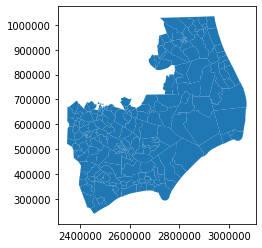

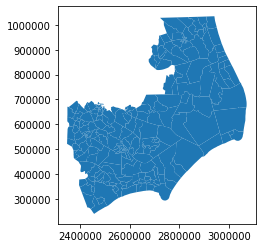

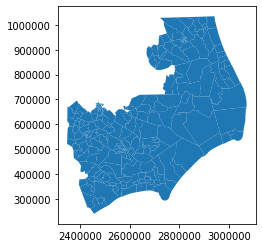

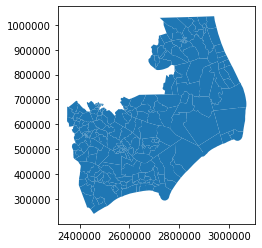

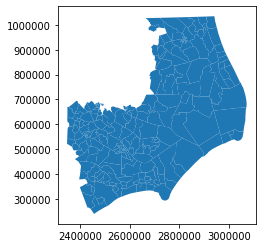

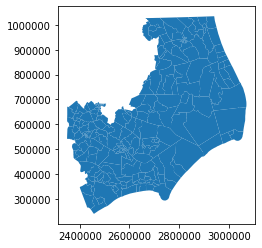

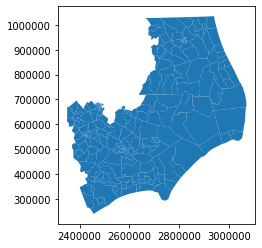

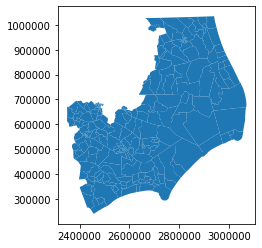

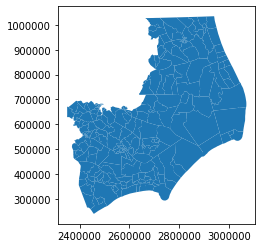

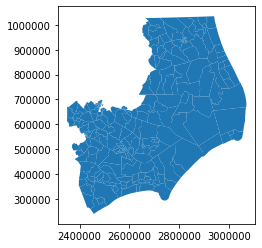

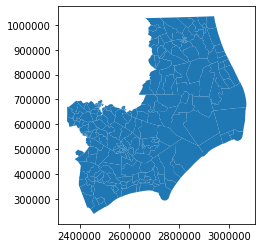

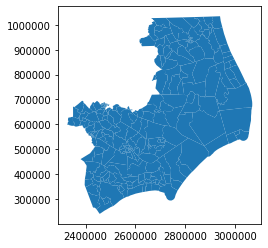

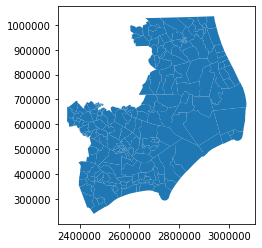

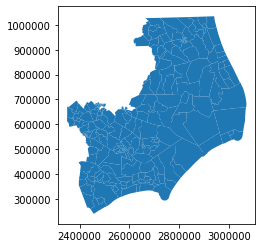

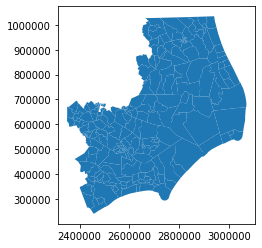

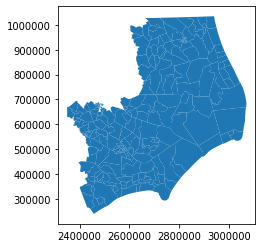

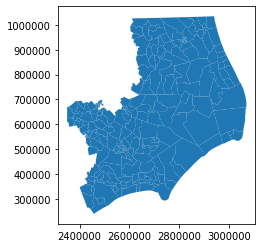

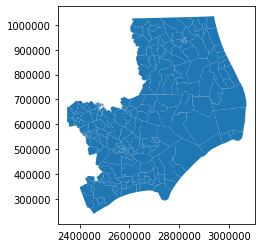

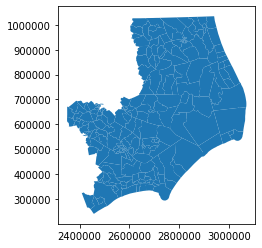

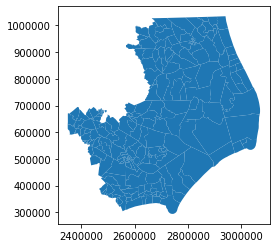

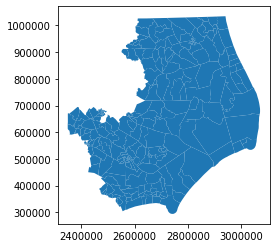

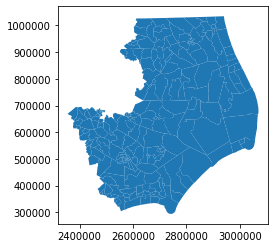

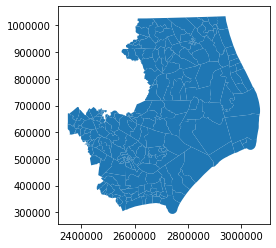

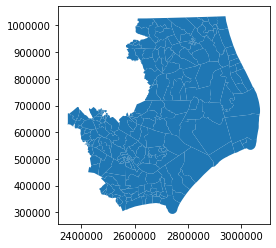

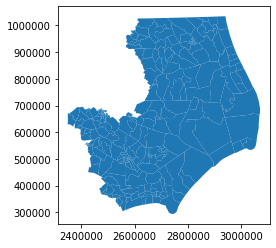

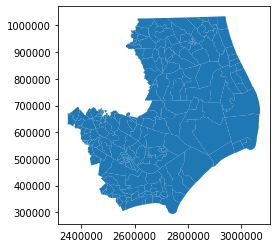

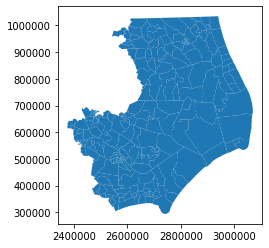

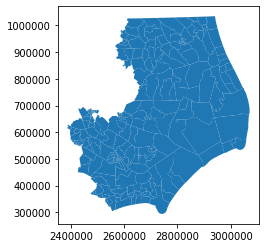

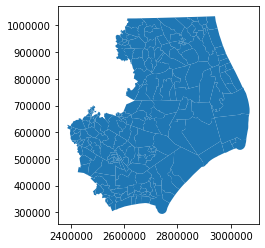

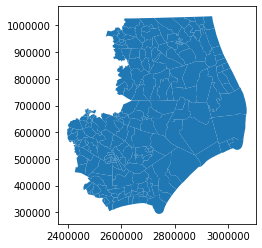

In [54]:
### Enter loop
##################################################

while True:
    count += 1
    print('========== LOOP', count, '==========')
    
    ### Get current district info
    district = state[state['district'] == NUM].copy()
    district.reset_index(drop=True, inplace=True)
    pop = district['total_pop'].sum() # Current total population
    dem = district['total_dem'].sum() # Current total dem votes
    rep = district['total_rep'].sum() # Current total rep votes
    votes = district['total_vote'].sum() # Current total votes
    mov = marginofvic(dem, rep, votes) # Current margin of victory
    new_mov = mov # Will be updated if a swap is made to the new margin of victory
    shape = district.unary_union # Current shape
    compact = polsby_popper(shape) # Current Polsby-Popper score

    print_head(NUM, district, pop, mov, compact)

    ### Get neighbouring precincts
    neighbours = get_neighbours(district)

    ### Get boundary precincts
    boundary = get_boundary(district, neighbours)

    ### Create what-if datafile

    whatif = basic_whatif(state)
    whatif = hyp_popdev(whatif, ideal_pop, pop)

    # Filter out precincts that, once swapped, will lead to a population deviation >0.5%
    whatif = whatif[whatif['hyp_popdev'] < 0.005].copy()

    if whatif.empty:
        print("No precincts with valid population deviation. End process.")
        break

    whatif = hyp_movchange(whatif, dem, rep, votes, mov)
    whatif = mov_prob(whatif, mov)

    ### Select precinct to be removed. Precincts with larger changes in margin of victory are more likely to be chosen.
    draw = 0
    while whatif.empty == False:
        p = np.array(whatif['mov_prob'])
        p = p * (1.0 / p.sum()) # Normalize probabilities
        draw = np.random.choice(whatif['loc_prec'].tolist(), size=1, p=p)
        draw = str(draw[0])
        new_shape = get_new_shape(whatif, draw, shape)

        # Check contiguity.  
        if check_contiguity(new_shape) == False:   
            whatif.drop(whatif[whatif['loc_prec'] == draw].index, inplace=True)
            draw = 0 # Reset draw value
            continue
        else:
            # Check compactness.
            if check_compactness(og_compact, new_shape) == False:
                whatif.drop(whatif[whatif['loc_prec'] == draw].index, inplace=True)
                draw = 0 # Reset draw value
                continue
            else:
                print('Found a precinct,', draw, 'with valid contiguity and compactness!') # Keep draw value
                break

    if draw == 0:
        print("No precincts with valid contiguity and compactness found. End process.")
        break
    else:
        # Check margin of victory.
        change = whatif.loc[whatif['loc_prec'] == draw, 'hyp_movchg'].values[0]
        if change < 0:
            print("Margin of victory for winning party decreases! Make swap.")
            ##################################################### INSERT SWAP
            swap_prec(state, draw, NUM, count)
            successful += 1
            new_mov = whatif.loc[whatif['loc_prec'] == draw, 'hyp_mov'].values[0]
        else:
            print("Margin of victory does not decrease. Make swap?")
            prob = prob_swap(whatif, draw, T)
            print("Probability of making the swap:", prob)
            swap = np.random.choice([1, 0], 1, [prob, 1-prob])
            if swap[0] == 1:
                print("Make swap anyways!")
                ##################################################### INSERT SWAP
                swap_prec(state, draw, NUM, count)
                successful += 1
                new_mov = whatif.loc[whatif['loc_prec'] == draw, 'hyp_mov'].values[0]
            else:
                print('Don\'t make swap.')
                unsuccessful += 1
 
    print("New mov:", new_mov)
    
    ### Check if successful and unsuccessful thresholds have been exceeded.

    if check_mov_goal(og_dem_win, new_mov, mov_goal) == True:
        print("Reached mov_goal with new margin of victory", new_mov, "End process.")
        break
    else:
        if successful > threshold or unsuccessful > threshold:
            if (T <= T_min):
                T = T_min
                print("Thresholds reached, but T already at a minumum of", T, "Starting new loop.")
            else:
                T = T - reduction
                successful = 0
                unsuccessful = 0
                print("Thresholds reached. Reset with new T value of", T, "and starting new loop.")

    if count % 50 == 0:
        new_district = state[state['district'] == NUM].copy()
        new_district.plot()
        print("In progress district plotted.")
    
    print('\n')

In [55]:
# End timing
end = time.time()

In [56]:
seconds = end - start
min = seconds/60
print(min)

# First time testing district 3
# It was getting long and seeming to oscillate around -0.22 to -0.23 for a couple min 
# so I just ended the loop manually.
# Not sure if we would want to actually show whether it would ever "end" or if it could keep oscillating forever?
# Then implement changes?
# Second time testing district 3 (which is what the current results are for)
# I simply set the cut-off as approx the value of the hypothetical district generated by the brute force method.
# Just from comparing these two results, it looks like like for a long time 
# the code was genuinely oscillating between same range? Not sure if it's something we would to pursue further.

32.045776577790576


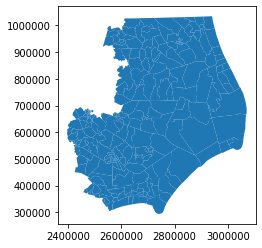

In [57]:
# New district plot
new_district = state[state['district'] == NUM].copy()
new_district.plot()

In [58]:
# New district compactness
shape = new_district.unary_union
polsby_popper(shape)

0.36631069170059727

In [59]:
# New district MoV
dem = new_district['total_dem'].sum() # Current total dem votes
rep = new_district['total_rep'].sum() # Current total rep votes
votes = new_district['total_vote'].sum() 
margin = marginofvic(dem, rep, votes)
margin

-0.2190560515212703

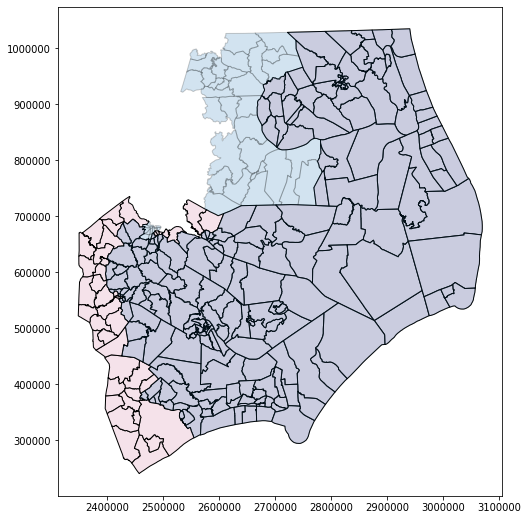

In [60]:
# Plot comparison
original = data[data['district'] == NUM].copy()
base = original.plot(figsize=(12, 9), edgecolor='black', color='#F5E2EA', linewidth=1)
new_district.plot(ax=base, alpha=0.2, edgecolor='black')